In [2]:
import numpy as np
import pandas as pd
import random
import math
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
import sklearn as sk
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def getData(df):
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change']]
    high = df['High']
    low = df['Low']
    change = df['Change']
    change_array = []
    delist_array = []
    for i in range(len(df)):
        if high[i] != low[i]:
            delist_array.append(1)
            if change[i] > 0.1:
                change_array.append(0.1)
            elif change[i] < -0.1:
                change_array.append(-0.1)
            else:
                change_array.append(change[i])
        else:
            delist_array.append(0)
    df['Change_update'] = pd.DataFrame(change_array)
    df['delist'] = pd.DataFrame(delist_array)
    
    # 去除当日停牌数据
    df = df[df['delist'].isin([1])]
    return df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change_update']]

def min_max_range(x, range_values):
    return [round( ((xx - min(x)) / (1.0*(max(x) - min(x))))
                  * (range_values[1] - range_values[0]) + range_values[0], 2) for xx in x]

def DataProcess(df):
    df  = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change_update']]
    
    data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change_update']].values
    label = df['Change_update'].values
    
    open_data = df['Open'].values
    high_data = df['High'].values
    low_data = df['Low'].values
    close_data = df['Close'].values
    volume_data = df['Volume'].values
    change_data = df['Change_update'].values
    
    open_data = min_max_range(open_data, (0, 255))
    high_data = min_max_range(high_data, (0, 255))
    low_data = min_max_range(low_data, (0, 255))
    close_data = min_max_range(close_data, (0, 255))
    volume_data = min_max_range(volume_data, (0, 255))
    change_data = min_max_range(change_data, (0, 255))
    df['open_1'] = pd.DataFrame(open_data)
    df['high_1'] = pd.DataFrame(high_data)
    df['low_1'] = pd.DataFrame(low_data)
    df['close_1'] = pd.DataFrame(close_data)
    df['volume_1'] = pd.DataFrame(volume_data)
    df['change_1'] = pd.DataFrame(change_data)
    
    df = df[['open_1', 'high_1', 'low_1', 'close_1', 'volume_1', 'change_1']]
    
    label_array = []
    for i in range(len(label)):
        if label[i] > 0:
            label_array.append(2)
        elif label[i] == 0:
            label_array.append(1)
        else:
            label_array.append(0)
    return df, label_array

def win(data, label, PastDays):
    newt = []
    newtr = []
    newtl = []
    newl = []
    for i in range(len(data)-PastDays+1):
        for j in range(PastDays):
            if(j < PastDays-1):                
                newt.append(data[i+j])
                newl.append(label[i+j])
            else:        
                newtr.append(newt)
                newtl.append(newl)
                newt = []
                newl = []
    dataset = np.array(newtr)
    labelset = np.array(newtl)
    
    # 赋予label
    # 采用每个batch中出现次数最多的数字作为这个batch的标签
    label = []
    for i in range(len(labelset)):
        tmp = list(labelset[i])
        label.append(max(set(tmp), key=tmp.count))
    
    return dataset, label

In [3]:
def acc_loss_fig(model_log):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model_log.history['acc'])
    plt.plot(model_log.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

    plt.subplot(2, 1, 2)
    plt.plot(model_log.history['loss'])
    plt.plot(model_log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.tight_layout()
    plt.show()

In [11]:
def model(stock_csv):
    df = pd.read_csv(stock_csv)
    close = df['Close']
    df['Change'] = (close-close.shift(1))/close.shift(1)

    # 拆分训练数据与测试数据并获取标签
    data_num = df.shape[0]
    data = getData(df)
    data = data.dropna(axis=0)
    data_1, label_1 = DataProcess(data)
    data_1 = data_1.dropna(axis=0)
    data_values = data_1.values

    data_win, label_win = win(data_values, label_1, PastDays)

    num1 = len(data_win)
    num2 = math.floor(num1*0.70)
    data_random = list(range(0, num1))
    random.shuffle(data_random)
    train_random = data_random[0:num2]
    test_random = data_random[num2:]

    train_data_random = []
    test_data_random = []
    train_label_random = []
    test_label_random = []
    for item in train_random:
        train_data_random.append(data_win[item])
        train_label_random.append(label_win[item])
    for item in test_random:
        test_data_random.append(data_win[item])
        test_label_random.append(label_win[item])

    train_labelset_01 = np_utils.to_categorical(train_label_random, n_classes)
    test_labelset_01 = np_utils.to_categorical(test_label_random, n_classes)


    img_cols = PastDays-1
    img_rows = FeatureNums
    input_shape = (img_cols, img_rows, 1)

    train_data_random_array = np.array(train_data_random)
    test_data_random_array = np.array(test_data_random)

    X_train = train_data_random_array.reshape(len(train_data_random), img_cols, img_rows, 1)
    X_test  = test_data_random_array.reshape(len(test_data_random), img_cols, img_rows, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    y_train = train_labelset_01
    y_test = test_labelset_01

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    if X_train.shape[0] == 0:
        return 
    else:
        # 2D model
        model = Sequential()
        model.add(Convolution2D(n_filters,
                                             kernel_size=(kernel_size[0], kernel_size[1]),
                                             input_shape=input_shape,
                                             activation='relu'))
        model.add(MaxPooling2D(pool_size=(pool_size[0], pool_size[1])))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, init='normal', activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(n_classes, init='normal', activation='softmax'))

        model.summary()

        # 保存模型的权重
        # checkpoint best neural network model only
        filepath = "2DCNN." + stock_csv + ".weight.best.h5"

        # checkpoint
        checkpoint = ModelCheckpoint(filepath,
                                                     monitor='val_acc',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     mode='max')

        model.compile(loss=keras.losses.categorical_crossentropy,
                             optimizer=keras.optimizers.Adadelta(),
                             metrics=['accuracy'])

        model.save_weights(filepath)

        model_log = model.fit(X_train, y_train,
                                       batch_size=batch_size,
                                       epochs=num_epoch,
                                       verbose=1,
                                       validation_data=(X_test, y_test),
                                       callbacks=[checkpoint])
        acc_loss_fig(model_log)
    
        model.load_weights(filepath)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        y_pred = np_utils.to_categorical(y_pred, n_classes)
        y_true = y_test
        F1_value = f1_score(y_true, y_pred, average='weighted')
        conf_matrix = sk.metrics.confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
        score = model.evaluate(X_test, y_test, verbose=0)
        print("F1_score = ", F1_value)
        print("confusion matrix\n", conf_matrix)
        print("Test Score = ", score[0])
        print("Test accuracy = ", score[1])
        return filepath, F1_value, conf_matrix, score[0], score[1]

In [5]:
PastDays = 6
n_classes = 3
FeatureNums = 6
batch_size = 32
num_epoch = 50

n_filters = 32
kernel_size = [3, 3]
pool_size = [2, 2]

In [3]:
stock_code = pd.read_csv("212NYSE_Composite_stock_code.csv")
stock_csv = stock_code.values

In [4]:
print(stock_csv)

[['XXII.csv']
 ['FAX.csv']
 ['IAF.csv']
 ['FCO.csv']
 ['ACU.csv']
 ['ATNM.csv']
 ['AIRI.csv']
 ['AXU.csv']
 ['ALO.csv']
 ['AAU.csv']
 ['APT.csv']
 ['AAMC.csv']
 ['DIT.csv']
 ['AMS.csv']
 ['AKG.csv']
 ['AWX.csv']
 ['ASM.csv']
 ['BTG.csv']
 ['BTN.csv']
 ['BKJ.csv']
 ['BCV.csv']
 ['BHB.csv']
 ['BRN.csv']
 ['BTX.csv']
 ['BGI.csv']
 ['BDR.csv']
 ['BRG.csv']
 ['CEI.csv']
 ['CANF.csv']
 ['ROX.csv']
 ['CVM.csv']
 ['CET.csv']
 ['LEU.csv']
 ['CCF.csv']
 ['LNG.csv']
 ['CVR.csv']
 ['CKX.csv']
 ['GLV.csv']
 ['GLQ.csv']
 ['GLO.csv']
 ['COHN.csv']
 ['CIX.csv']
 ['LODE.csv']
 ['CTO.csv']
 ['MCF.csv']
 ['CUO.csv']
 ['CVM.csv']
 ['CVRS.csv']
 ['CRMD.csv']
 ['CLM.csv']
 ['CRF.csv']
 ['CVU.csv']
 ['CIK.csv']
 ['DHY.csv']
 ['CRHM.csv']
 ['DXR.csv']
 ['VCF.csv']
 ['VMM.csv']
 ['VFL.csv']
 ['DLA.csv']
 ['DNN.csv']
 ['DGSE.csv']
 ['DSS.csv']
 ['DPW.csv']
 ['DMF.csv']
 ['GRF.csv']
 ['EVM.csv']
 ['CEV.csv']
 ['EVV.csv']
 ['EIM.csv']
 ['ENX.csv']
 ['EVY.csv']
 ['ELMD.csv']
 ['ELLO.csv']
 ['ECF.csv']
 ['EMAN.csv'

XXII.csv


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(816, 5, 6, 1) (816, 3)
(351, 5, 6, 1) (351, 3)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_____________________

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="softmax", kernel_initializer="normal")`


Train on 816 samples, validate on 351 samples
Epoch 1/50
816/816 [==============================] - 1s 627us/step - loss: 2.1858 - acc: 0.4203 - val_loss: 1.3642 - val_acc: 0.5670
Epoch 2/50
816/816 [==============================] - 0s 77us/step - loss: 1.3648 - acc: 0.5245 - val_loss: 0.9145 - val_acc: 0.5670
Epoch 3/50
816/816 [==============================] - 0s 86us/step - loss: 1.2987 - acc: 0.4902 - val_loss: 0.9352 - val_acc: 0.5641
Epoch 4/50
816/816 [==============================] - 0s 110us/step - loss: 1.0905 - acc: 0.5147 - val_loss: 0.8182 - val_acc: 0.5783
Epoch 5/50
816/816 [==============================] - 0s 87us/step - loss: 1.0205 - acc: 0.5123 - val_loss: 0.8239 - val_acc: 0.5726
Epoch 6/50
816/816 [==============================] - 0s 89us/step - loss: 0.9246 - acc: 0.5441 - val_loss: 0.8326 - val_acc: 0.5641
Epoch 7/50
816/816 [==============================] - 0s 79us/step - loss: 0.8964 - acc: 0.5502 - val_loss: 0.8206 - val_acc: 0.5698
Epoch 8/50
816/816 [=

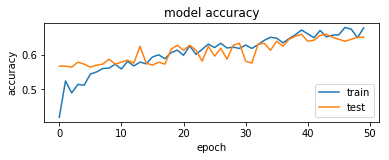

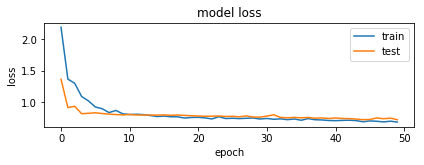

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1_score =  0.6300299517184524
confusion matrix
 [[170   0  29]
 [ 11   0   2]
 [ 78   0  61]]
Test Score =  0.7421838371162741
Test accuracy =  0.6581196589687272
---------------
FAX.csv
(5513, 5, 6, 1) (5513, 3)
(2364, 5, 6, 1) (2364, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
__________________________________

Epoch 25/50
5513/5513 [==============================] - 0s 81us/step - loss: 0.8964 - acc: 0.5864 - val_loss: 0.8858 - val_acc: 0.5470
Epoch 26/50
5513/5513 [==============================] - 0s 78us/step - loss: 0.8907 - acc: 0.5911 - val_loss: 0.8767 - val_acc: 0.6129
Epoch 27/50
5513/5513 [==============================] - 0s 80us/step - loss: 0.8872 - acc: 0.5951 - val_loss: 0.8452 - val_acc: 0.6540
Epoch 28/50
5513/5513 [==============================] - 0s 80us/step - loss: 0.8957 - acc: 0.5846 - val_loss: 0.8559 - val_acc: 0.6303
Epoch 29/50
5513/5513 [==============================] - 0s 79us/step - loss: 0.8930 - acc: 0.5882 - val_loss: 0.8462 - val_acc: 0.6307
Epoch 30/50
5513/5513 [==============================] - 0s 81us/step - loss: 0.8856 - acc: 0.5959 - val_loss: 0.9413 - val_acc: 0.5427
Epoch 31/50
5513/5513 [==============================] - 0s 81us/step - loss: 0.8804 - acc: 0.5984 - val_loss: 0.8542 - val_acc: 0.6265
Epoch 32/50
5513/5513 [=========================

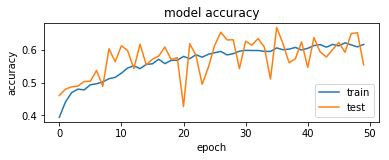

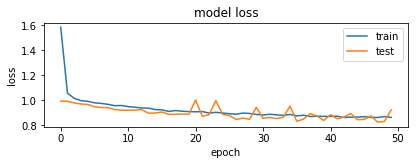

F1_score =  0.6468071136456585
confusion matrix
 [[959  22 157]
 [222 113  97]
 [268  18 508]]
Test Score =  0.8307406085396781
Test accuracy =  0.668358714245701
---------------
IAF.csv
(5378, 5, 6, 1) (5378, 3)
(2306, 5, 6, 1) (2306, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
___________________________________

Epoch 25/50
5378/5378 [==============================] - 0s 88us/step - loss: 0.8456 - acc: 0.6036 - val_loss: 0.9407 - val_acc: 0.5312
Epoch 26/50
5378/5378 [==============================] - 0s 89us/step - loss: 0.8440 - acc: 0.6060 - val_loss: 0.8161 - val_acc: 0.6500
Epoch 27/50
5378/5378 [==============================] - 0s 85us/step - loss: 0.8364 - acc: 0.5987 - val_loss: 0.8680 - val_acc: 0.5507
Epoch 28/50
5378/5378 [==============================] - 0s 86us/step - loss: 0.8356 - acc: 0.6112 - val_loss: 0.8649 - val_acc: 0.5880
Epoch 29/50
5378/5378 [==============================] - 0s 89us/step - loss: 0.8371 - acc: 0.6112 - val_loss: 0.9220 - val_acc: 0.5291
Epoch 30/50
5378/5378 [==============================] - 0s 88us/step - loss: 0.8316 - acc: 0.6112 - val_loss: 0.8057 - val_acc: 0.6466
Epoch 31/50
5378/5378 [==============================] - 0s 91us/step - loss: 0.8321 - acc: 0.6104 - val_loss: 0.9817 - val_acc: 0.4744
Epoch 32/50
5378/5378 [=========================

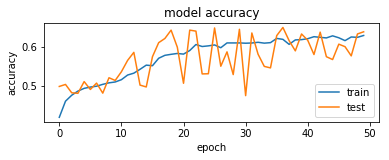

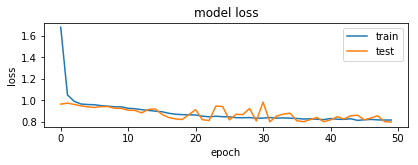

F1_score =  0.6477533980441236
confusion matrix
 [[772  77 260]
 [113 107  82]
 [215  57 623]]
Test Score =  0.7994313000702176
Test accuracy =  0.6513443191673894
---------------
FCO.csv
(4589, 5, 6, 1) (4589, 3)
(1967, 5, 6, 1) (1967, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
__________________________________

Epoch 25/50
4589/4589 [==============================] - 0s 91us/step - loss: 0.8850 - acc: 0.5716 - val_loss: 0.8337 - val_acc: 0.5968
Epoch 26/50
4589/4589 [==============================] - 0s 93us/step - loss: 0.8796 - acc: 0.5831 - val_loss: 0.8492 - val_acc: 0.6121
Epoch 27/50
4589/4589 [==============================] - 0s 86us/step - loss: 0.8774 - acc: 0.5836 - val_loss: 0.8846 - val_acc: 0.5343
Epoch 28/50
4589/4589 [==============================] - 0s 84us/step - loss: 0.8832 - acc: 0.5711 - val_loss: 0.8534 - val_acc: 0.5765
Epoch 29/50
4589/4589 [==============================] - 0s 89us/step - loss: 0.8842 - acc: 0.5794 - val_loss: 0.8339 - val_acc: 0.6304
Epoch 30/50
4589/4589 [==============================] - 0s 88us/step - loss: 0.8701 - acc: 0.5899 - val_loss: 0.8522 - val_acc: 0.6207
Epoch 31/50
4589/4589 [==============================] - 0s 86us/step - loss: 0.8814 - acc: 0.5814 - val_loss: 0.8341 - val_acc: 0.5796
Epoch 32/50
4589/4589 [=========================

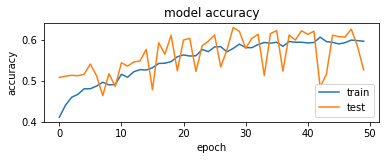

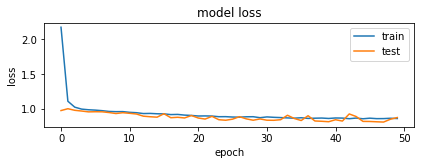

F1_score =  0.5846547037693898
confusion matrix
 [[782   2 225]
 [208   5  71]
 [220   1 453]]
Test Score =  0.8338530027569401
Test accuracy =  0.6304016270247218
---------------
ACU.csv
(1113, 5, 6, 1) (1113, 3)
(478, 5, 6, 1) (478, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
____________________________________

Epoch 26/50
1113/1113 [==============================] - 0s 102us/step - loss: 0.9861 - acc: 0.5121 - val_loss: 0.9721 - val_acc: 0.5293
Epoch 27/50
1113/1113 [==============================] - 0s 94us/step - loss: 0.9935 - acc: 0.4933 - val_loss: 0.9633 - val_acc: 0.5126
Epoch 28/50
1113/1113 [==============================] - 0s 103us/step - loss: 0.9697 - acc: 0.5121 - val_loss: 0.9793 - val_acc: 0.4812
Epoch 29/50
1113/1113 [==============================] - 0s 95us/step - loss: 0.9871 - acc: 0.5130 - val_loss: 0.9778 - val_acc: 0.5042
Epoch 30/50
1113/1113 [==============================] - 0s 101us/step - loss: 0.9698 - acc: 0.5157 - val_loss: 0.9746 - val_acc: 0.4916
Epoch 31/50
1113/1113 [==============================] - 0s 98us/step - loss: 0.9759 - acc: 0.5076 - val_loss: 0.9620 - val_acc: 0.5816
Epoch 32/50
1113/1113 [==============================] - 0s 99us/step - loss: 0.9700 - acc: 0.5229 - val_loss: 0.9609 - val_acc: 0.5586
Epoch 33/50
1113/1113 [======================

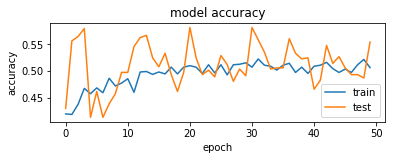

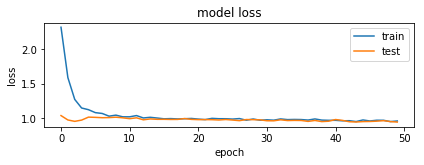

F1_score =  0.45153497119132374
confusion matrix
 [[267   0   2]
 [ 69   0   0]
 [129   0  11]]
Test Score =  0.9779618045774963
Test accuracy =  0.5815899599047385
---------------
ATNM.csv
(785, 5, 6, 1) (785, 3)
(337, 5, 6, 1) (337, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
____________________________________

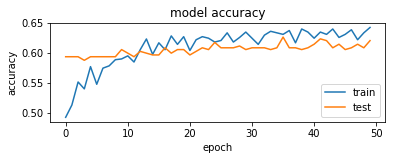

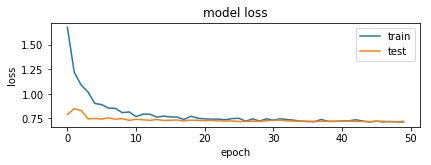

F1_score =  0.5404611427461081
confusion matrix
 [[192   0   8]
 [  5   0   0]
 [113   0  19]]
Test Score =  0.7209338903073387
Test accuracy =  0.6261127607051272
---------------
AIRI.csv
(165, 5, 6, 1) (165, 3)
(72, 5, 6, 1) (72, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_______________________________________

Epoch 27/50
165/165 [==============================] - 0s 138us/step - loss: 1.0157 - acc: 0.5394 - val_loss: 0.8821 - val_acc: 0.6667
Epoch 28/50
165/165 [==============================] - 0s 133us/step - loss: 1.1008 - acc: 0.5455 - val_loss: 0.8839 - val_acc: 0.6667
Epoch 29/50
165/165 [==============================] - 0s 124us/step - loss: 1.0407 - acc: 0.6061 - val_loss: 0.8797 - val_acc: 0.6667
Epoch 30/50
165/165 [==============================] - 0s 141us/step - loss: 1.0355 - acc: 0.5636 - val_loss: 0.8871 - val_acc: 0.6528
Epoch 31/50
165/165 [==============================] - 0s 123us/step - loss: 1.0243 - acc: 0.6061 - val_loss: 0.8887 - val_acc: 0.6806
Epoch 32/50
165/165 [==============================] - 0s 135us/step - loss: 0.9721 - acc: 0.6182 - val_loss: 0.8858 - val_acc: 0.6667
Epoch 33/50
165/165 [==============================] - 0s 133us/step - loss: 1.0227 - acc: 0.6061 - val_loss: 0.8971 - val_acc: 0.6528
Epoch 34/50
165/165 [==============================] - 

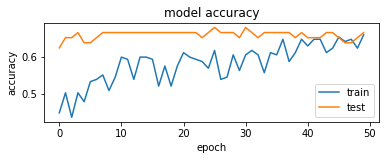

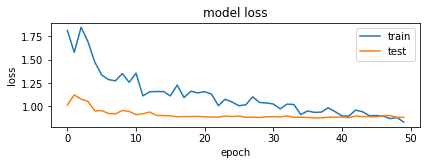

F1_score =  0.5638567927170869
confusion matrix
 [[48  0  0]
 [14  1  0]
 [ 9  0  0]]
Test Score =  0.8956540624300638
Test accuracy =  0.6805555555555556
---------------
AXU.csv
(2186, 5, 6, 1) (2186, 3)
(938, 5, 6, 1) (938, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               8320      
_____________________________________________

Epoch 25/50
2186/2186 [==============================] - 0s 116us/step - loss: 0.7490 - acc: 0.6162 - val_loss: 0.7093 - val_acc: 0.6759
Epoch 26/50
2186/2186 [==============================] - 0s 100us/step - loss: 0.7313 - acc: 0.6464 - val_loss: 0.7279 - val_acc: 0.6748
Epoch 27/50
2186/2186 [==============================] - 0s 105us/step - loss: 0.7234 - acc: 0.6455 - val_loss: 0.7217 - val_acc: 0.6876
Epoch 28/50
2186/2186 [==============================] - 0s 109us/step - loss: 0.7356 - acc: 0.6336 - val_loss: 0.7042 - val_acc: 0.6439
Epoch 29/50
2186/2186 [==============================] - 0s 117us/step - loss: 0.7235 - acc: 0.6446 - val_loss: 0.7608 - val_acc: 0.6194
Epoch 30/50
2186/2186 [==============================] - 0s 111us/step - loss: 0.7161 - acc: 0.6551 - val_loss: 0.7097 - val_acc: 0.6844
Epoch 31/50
2186/2186 [==============================] - 0s 112us/step - loss: 0.7184 - acc: 0.6560 - val_loss: 0.6877 - val_acc: 0.6951
Epoch 32/50
2186/2186 [==================

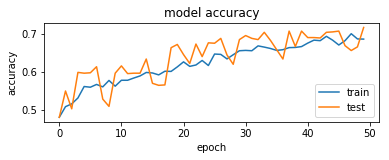

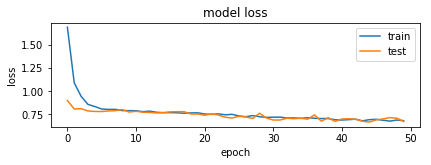

F1_score =  0.6906848018796166
confusion matrix
 [[506   1  53]
 [ 33   2   3]
 [174   2 164]]
Test Score =  0.6726263685267109
Test accuracy =  0.7164179103206724
---------------
ALO.csv
(1691, 5, 6, 1) (1691, 3)
(726, 5, 6, 1) (726, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320      
____________________________________

Epoch 27/50
1691/1691 [==============================] - 0s 104us/step - loss: 0.8427 - acc: 0.5778 - val_loss: 0.8332 - val_acc: 0.6088
Epoch 28/50
1691/1691 [==============================] - 0s 104us/step - loss: 0.8376 - acc: 0.5801 - val_loss: 0.8268 - val_acc: 0.6074
Epoch 29/50
1691/1691 [==============================] - 0s 102us/step - loss: 0.8474 - acc: 0.5801 - val_loss: 0.8245 - val_acc: 0.6074
Epoch 30/50
1691/1691 [==============================] - 0s 100us/step - loss: 0.8418 - acc: 0.5884 - val_loss: 0.8359 - val_acc: 0.5758
Epoch 31/50
1691/1691 [==============================] - 0s 98us/step - loss: 0.8410 - acc: 0.5843 - val_loss: 0.8272 - val_acc: 0.6061
Epoch 32/50
1691/1691 [==============================] - 0s 103us/step - loss: 0.8441 - acc: 0.5849 - val_loss: 0.8285 - val_acc: 0.6074
Epoch 33/50
1691/1691 [==============================] - 0s 101us/step - loss: 0.8346 - acc: 0.5843 - val_loss: 0.8239 - val_acc: 0.6074
Epoch 34/50
1691/1691 [===================

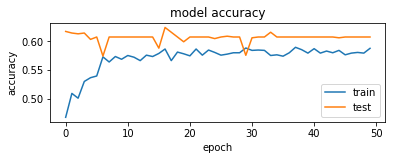

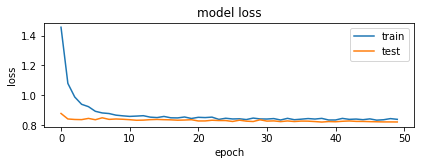

F1_score =  0.5421418355237636
confusion matrix
 [[412   0  29]
 [ 63   0   0]
 [181   0  41]]
Test Score =  0.8356709677325792
Test accuracy =  0.62396694182036
---------------
AAU.csv
(2353, 5, 6, 1) (2353, 3)
(1009, 5, 6, 1) (1009, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320      
____________________________________

Epoch 26/50
2353/2353 [==============================] - 0s 95us/step - loss: 0.6984 - acc: 0.6740 - val_loss: 0.6973 - val_acc: 0.6957
Epoch 27/50
2353/2353 [==============================] - 0s 103us/step - loss: 0.6975 - acc: 0.6753 - val_loss: 0.6903 - val_acc: 0.7136
Epoch 28/50
2353/2353 [==============================] - 0s 100us/step - loss: 0.6849 - acc: 0.6919 - val_loss: 0.6711 - val_acc: 0.7195
Epoch 29/50
2353/2353 [==============================] - 0s 94us/step - loss: 0.6821 - acc: 0.6898 - val_loss: 0.7055 - val_acc: 0.6492
Epoch 30/50
2353/2353 [==============================] - 0s 95us/step - loss: 0.6788 - acc: 0.6898 - val_loss: 0.6788 - val_acc: 0.7056
Epoch 31/50
2353/2353 [==============================] - 0s 93us/step - loss: 0.6773 - acc: 0.6936 - val_loss: 0.6794 - val_acc: 0.7096
Epoch 32/50
2353/2353 [==============================] - 0s 96us/step - loss: 0.6760 - acc: 0.7012 - val_loss: 0.6713 - val_acc: 0.7056
Epoch 33/50
2353/2353 [=======================

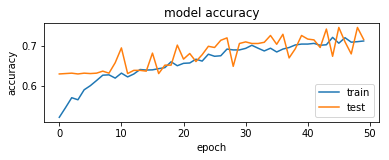

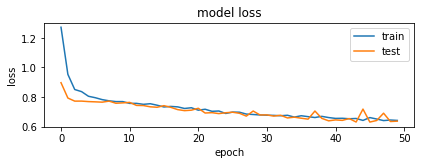

F1_score =  0.7189898367803353
confusion matrix
 [[582   0  55]
 [ 32   0   4]
 [166   0 170]]
Test Score =  0.6309402657098647
Test accuracy =  0.7452923690953741
---------------
APT.csv
(3395, 5, 6, 1) (3395, 3)
(1456, 5, 6, 1) (1456, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               8320      
__________________________________

Epoch 25/50
3395/3395 [==============================] - 0s 100us/step - loss: 0.8560 - acc: 0.6159 - val_loss: 0.8224 - val_acc: 0.6168
Epoch 26/50
3395/3395 [==============================] - 0s 97us/step - loss: 0.8480 - acc: 0.6242 - val_loss: 0.8049 - val_acc: 0.6401
Epoch 27/50
3395/3395 [==============================] - 0s 96us/step - loss: 0.8481 - acc: 0.6247 - val_loss: 0.8599 - val_acc: 0.6044
Epoch 28/50
3395/3395 [==============================] - 0s 106us/step - loss: 0.8475 - acc: 0.6342 - val_loss: 0.8001 - val_acc: 0.6621
Epoch 29/50
3395/3395 [==============================] - 0s 97us/step - loss: 0.8449 - acc: 0.6215 - val_loss: 0.8022 - val_acc: 0.6408
Epoch 30/50
3395/3395 [==============================] - 0s 97us/step - loss: 0.8389 - acc: 0.6327 - val_loss: 0.7971 - val_acc: 0.6580
Epoch 31/50
3395/3395 [==============================] - 0s 101us/step - loss: 0.8371 - acc: 0.6292 - val_loss: 0.7879 - val_acc: 0.6669
Epoch 32/50
3395/3395 [======================

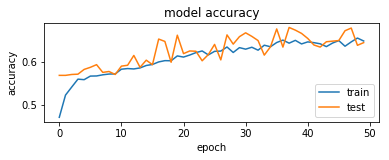

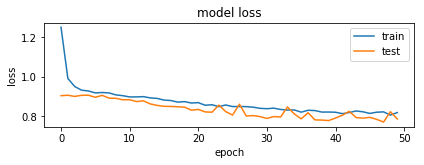

F1_score =  0.6472381194836271
confusion matrix
 [[685   0 143]
 [ 82   0  35]
 [207   0 304]]
Test Score =  0.7804358948718061
Test accuracy =  0.6792582417582418
---------------
AAMC.csv
(837, 5, 6, 1) (837, 3)
(359, 5, 6, 1) (359, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               8320      
_____________________________________

837/837 [==============================] - 0s 106us/step - loss: 0.6751 - acc: 0.6022 - val_loss: 0.6919 - val_acc: 0.5460
Epoch 27/50
837/837 [==============================] - 0s 106us/step - loss: 0.6866 - acc: 0.5687 - val_loss: 0.6890 - val_acc: 0.5404
Epoch 28/50
837/837 [==============================] - 0s 138us/step - loss: 0.6637 - acc: 0.5747 - val_loss: 0.6634 - val_acc: 0.6184
Epoch 29/50
837/837 [==============================] - 0s 108us/step - loss: 0.6652 - acc: 0.5878 - val_loss: 0.6896 - val_acc: 0.5515
Epoch 30/50
837/837 [==============================] - 0s 133us/step - loss: 0.6767 - acc: 0.5759 - val_loss: 0.6605 - val_acc: 0.6295
Epoch 31/50
837/837 [==============================] - 0s 110us/step - loss: 0.6584 - acc: 0.6081 - val_loss: 0.6635 - val_acc: 0.6128
Epoch 32/50
837/837 [==============================] - 0s 129us/step - loss: 0.6691 - acc: 0.6033 - val_loss: 0.6537 - val_acc: 0.6518
Epoch 33/50
837/837 [==============================] - 0s 111us/ste

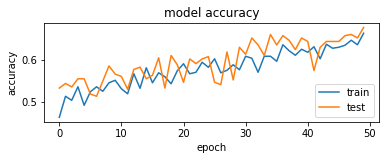

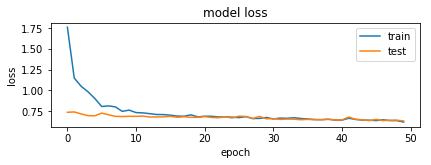

F1_score =  0.6685444988385975
confusion matrix
 [[150   0  32]
 [  1   0   0]
 [ 83   0  93]]
Test Score =  0.63445815502103
Test accuracy =  0.6768802233393146
---------------
DIT.csv
(410, 5, 6, 1) (410, 3)
(177, 5, 6, 1) (177, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               8320      
________________________________________

Epoch 27/50
410/410 [==============================] - 0s 102us/step - loss: 0.7531 - acc: 0.6341 - val_loss: 0.7613 - val_acc: 0.5763
Epoch 28/50
410/410 [==============================] - 0s 98us/step - loss: 0.7607 - acc: 0.6122 - val_loss: 0.7714 - val_acc: 0.5706
Epoch 29/50
410/410 [==============================] - 0s 100us/step - loss: 0.7714 - acc: 0.6512 - val_loss: 0.7611 - val_acc: 0.5819
Epoch 30/50
410/410 [==============================] - 0s 103us/step - loss: 0.7777 - acc: 0.6317 - val_loss: 0.7626 - val_acc: 0.5819
Epoch 31/50
410/410 [==============================] - 0s 105us/step - loss: 0.7550 - acc: 0.6415 - val_loss: 0.7683 - val_acc: 0.5706
Epoch 32/50
410/410 [==============================] - 0s 107us/step - loss: 0.7488 - acc: 0.6585 - val_loss: 0.7671 - val_acc: 0.5706
Epoch 33/50
410/410 [==============================] - 0s 114us/step - loss: 0.7134 - acc: 0.6659 - val_loss: 0.7583 - val_acc: 0.5763
Epoch 34/50
410/410 [==============================] - 0

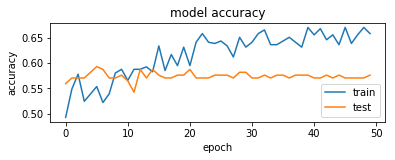

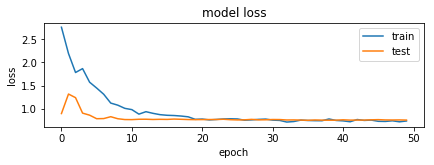

F1_score =  0.5275145691534321
confusion matrix
 [[91  0 10]
 [ 4  0  0]
 [58  0 14]]
Test Score =  0.7855212132809526
Test accuracy =  0.5932203410035473
---------------
AMS.csv
(1996, 5, 6, 1) (1996, 3)
(856, 5, 6, 1) (856, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               8320      
_____________________________________________

1996/1996 [==============================] - 0s 109us/step - loss: 1.0256 - acc: 0.4900 - val_loss: 1.0419 - val_acc: 0.4895
Epoch 27/50
1996/1996 [==============================] - 0s 101us/step - loss: 1.0327 - acc: 0.4955 - val_loss: 1.0372 - val_acc: 0.4871
Epoch 28/50
1996/1996 [==============================] - 0s 105us/step - loss: 1.0219 - acc: 0.4925 - val_loss: 1.0358 - val_acc: 0.4895
Epoch 29/50
1996/1996 [==============================] - 0s 104us/step - loss: 1.0191 - acc: 0.5020 - val_loss: 1.0367 - val_acc: 0.4930
Epoch 30/50
1996/1996 [==============================] - 0s 103us/step - loss: 1.0121 - acc: 0.5020 - val_loss: 1.0424 - val_acc: 0.4860
Epoch 31/50
1996/1996 [==============================] - 0s 106us/step - loss: 1.0259 - acc: 0.4945 - val_loss: 1.0332 - val_acc: 0.4883
Epoch 32/50
1996/1996 [==============================] - 0s 104us/step - loss: 1.0222 - acc: 0.4970 - val_loss: 1.0288 - val_acc: 0.4860
Epoch 33/50
1996/1996 [==============================

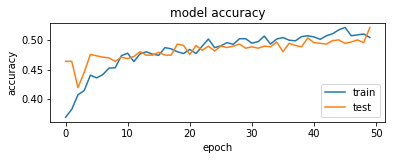

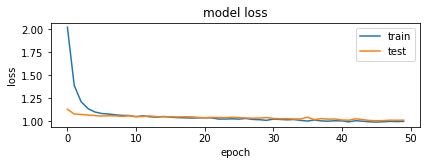

F1_score =  0.4550984890275188
confusion matrix
 [[342   4  51]
 [154  14  36]
 [158   7  90]]
Test Score =  1.0143684594430655
Test accuracy =  0.5210280376617039
---------------
AKG.csv
(2000, 5, 6, 1) (2000, 3)
(858, 5, 6, 1) (858, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               8320      
____________________________________

Epoch 26/50
2000/2000 [==============================] - 0s 107us/step - loss: 0.6753 - acc: 0.6620 - val_loss: 0.6235 - val_acc: 0.7284
Epoch 27/50
2000/2000 [==============================] - 0s 111us/step - loss: 0.6580 - acc: 0.6885 - val_loss: 0.6055 - val_acc: 0.7517
Epoch 28/50
2000/2000 [==============================] - 0s 104us/step - loss: 0.6682 - acc: 0.6820 - val_loss: 0.6000 - val_acc: 0.7424
Epoch 29/50
2000/2000 [==============================] - 0s 104us/step - loss: 0.6430 - acc: 0.6880 - val_loss: 0.6167 - val_acc: 0.7273
Epoch 30/50
2000/2000 [==============================] - 0s 105us/step - loss: 0.6549 - acc: 0.6835 - val_loss: 0.6443 - val_acc: 0.6655
Epoch 31/50
2000/2000 [==============================] - 0s 112us/step - loss: 0.6468 - acc: 0.6970 - val_loss: 0.5860 - val_acc: 0.7657
Epoch 32/50
2000/2000 [==============================] - 0s 108us/step - loss: 0.6526 - acc: 0.7170 - val_loss: 0.5966 - val_acc: 0.7657
Epoch 33/50
2000/2000 [==================

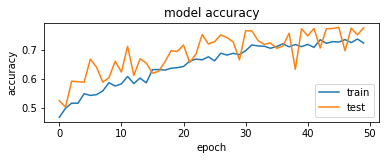

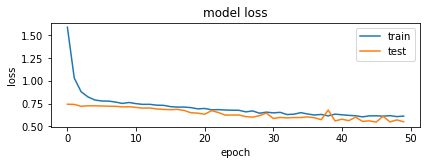

F1_score =  0.7712898907889965
confusion matrix
 [[401   0  82]
 [  8   0   4]
 [ 97   0 266]]
Test Score =  0.5458629489778639
Test accuracy =  0.7773892778060931
---------------
AWX.csv
(1076, 5, 6, 1) (1076, 3)
(462, 5, 6, 1) (462, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               8320      
____________________________________

Epoch 25/50
1076/1076 [==============================] - 0s 112us/step - loss: 0.8607 - acc: 0.5623 - val_loss: 0.8440 - val_acc: 0.5801
Epoch 26/50
1076/1076 [==============================] - 0s 108us/step - loss: 0.8483 - acc: 0.5892 - val_loss: 0.8382 - val_acc: 0.5887
Epoch 27/50
1076/1076 [==============================] - 0s 113us/step - loss: 0.8571 - acc: 0.5818 - val_loss: 0.8387 - val_acc: 0.5844
Epoch 28/50
1076/1076 [==============================] - 0s 109us/step - loss: 0.8295 - acc: 0.5939 - val_loss: 0.8322 - val_acc: 0.5866
Epoch 29/50
1076/1076 [==============================] - 0s 108us/step - loss: 0.8440 - acc: 0.5855 - val_loss: 0.8330 - val_acc: 0.5887
Epoch 30/50
1076/1076 [==============================] - 0s 111us/step - loss: 0.8497 - acc: 0.5929 - val_loss: 0.8301 - val_acc: 0.5952
Epoch 31/50
1076/1076 [==============================] - 0s 125us/step - loss: 0.8498 - acc: 0.5948 - val_loss: 0.8327 - val_acc: 0.6039
Epoch 32/50
1076/1076 [==================

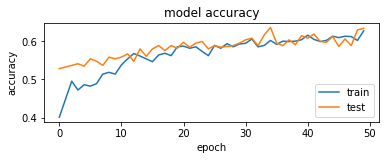

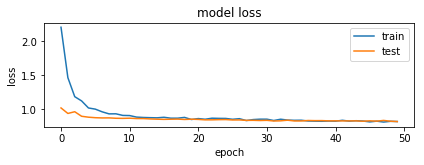

F1_score =  0.6065793034817073
confusion matrix
 [[204   0  44]
 [ 25   0   3]
 [ 96   0  90]]
Test Score =  0.8237061007714375
Test accuracy =  0.6363636366216652
---------------
ASM.csv
(1720, 5, 6, 1) (1720, 3)
(738, 5, 6, 1) (738, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               8320      
____________________________________

Epoch 25/50
1720/1720 [==============================] - 0s 135us/step - loss: 0.7811 - acc: 0.6145 - val_loss: 0.7337 - val_acc: 0.6518
Epoch 26/50
1720/1720 [==============================] - 0s 113us/step - loss: 0.7749 - acc: 0.6145 - val_loss: 0.7402 - val_acc: 0.6545
Epoch 27/50
1720/1720 [==============================] - 0s 97us/step - loss: 0.7744 - acc: 0.6267 - val_loss: 0.7274 - val_acc: 0.6396
Epoch 28/50
1720/1720 [==============================] - 0s 109us/step - loss: 0.7674 - acc: 0.6215 - val_loss: 0.7251 - val_acc: 0.6612
Epoch 29/50
1720/1720 [==============================] - 0s 103us/step - loss: 0.7618 - acc: 0.6215 - val_loss: 0.7350 - val_acc: 0.6450
Epoch 30/50
1720/1720 [==============================] - 0s 116us/step - loss: 0.7522 - acc: 0.6378 - val_loss: 0.7403 - val_acc: 0.6463
Epoch 31/50
1720/1720 [==============================] - 0s 109us/step - loss: 0.7578 - acc: 0.6471 - val_loss: 0.7107 - val_acc: 0.6463
Epoch 32/50
1720/1720 [===================

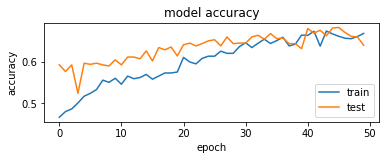

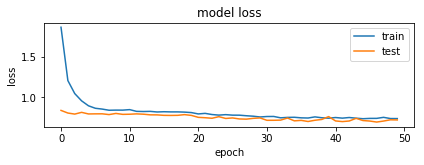

F1_score =  0.6588395707084558
confusion matrix
 [[379   0  58]
 [ 15   0   7]
 [153   0 126]]
Test Score =  0.7014859535183687
Test accuracy =  0.6842818428184282
---------------
BTG.csv
(1365, 5, 6, 1) (1365, 3)
(586, 5, 6, 1) (586, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               8320      
____________________________________

Epoch 26/50
1365/1365 [==============================] - 0s 106us/step - loss: 0.7026 - acc: 0.6147 - val_loss: 0.7037 - val_acc: 0.6502
Epoch 27/50
1365/1365 [==============================] - 0s 108us/step - loss: 0.7139 - acc: 0.6117 - val_loss: 0.6917 - val_acc: 0.6502
Epoch 28/50
1365/1365 [==============================] - 0s 103us/step - loss: 0.7121 - acc: 0.6095 - val_loss: 0.7170 - val_acc: 0.6041
Epoch 29/50
1365/1365 [==============================] - 0s 125us/step - loss: 0.6917 - acc: 0.6396 - val_loss: 0.6856 - val_acc: 0.6775
Epoch 30/50
1365/1365 [==============================] - 0s 110us/step - loss: 0.6877 - acc: 0.6227 - val_loss: 0.6880 - val_acc: 0.6331
Epoch 31/50
1365/1365 [==============================] - 0s 109us/step - loss: 0.6952 - acc: 0.6388 - val_loss: 0.7187 - val_acc: 0.5904
Epoch 32/50
1365/1365 [==============================] - 0s 110us/step - loss: 0.6960 - acc: 0.6286 - val_loss: 0.6970 - val_acc: 0.6451
Epoch 33/50
1365/1365 [==================

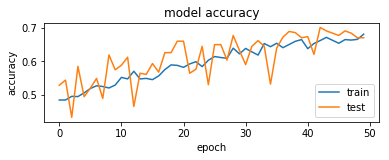

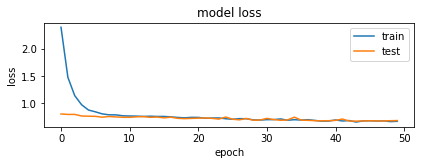

F1_score =  0.6972445603927926
confusion matrix
 [[235   0  85]
 [  4   0   3]
 [ 83   0 176]]
Test Score =  0.6697927282125062
Test accuracy =  0.7013651875098817
---------------
BTN.csv
(2637, 5, 6, 1) (2637, 3)
(1131, 5, 6, 1) (1131, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               8320      
__________________________________

Epoch 26/50
2637/2637 [==============================] - 0s 114us/step - loss: 0.7639 - acc: 0.6242 - val_loss: 0.7657 - val_acc: 0.6154
Epoch 27/50
2637/2637 [==============================] - 0s 114us/step - loss: 0.7756 - acc: 0.6253 - val_loss: 0.7472 - val_acc: 0.6790
Epoch 28/50
2637/2637 [==============================] - 0s 107us/step - loss: 0.7541 - acc: 0.6329 - val_loss: 0.8814 - val_acc: 0.5774
Epoch 29/50
2637/2637 [==============================] - 0s 114us/step - loss: 0.7765 - acc: 0.6193 - val_loss: 0.7425 - val_acc: 0.6782
Epoch 30/50
2637/2637 [==============================] - 0s 110us/step - loss: 0.7650 - acc: 0.6231 - val_loss: 0.7344 - val_acc: 0.6702
Epoch 31/50
2637/2637 [==============================] - 0s 109us/step - loss: 0.7713 - acc: 0.6250 - val_loss: 0.7513 - val_acc: 0.6304
Epoch 32/50
2637/2637 [==============================] - 0s 111us/step - loss: 0.7623 - acc: 0.6268 - val_loss: 0.7315 - val_acc: 0.6676
Epoch 33/50
2637/2637 [==================

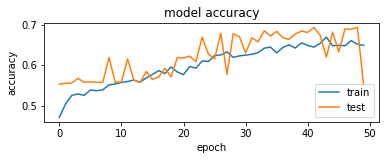

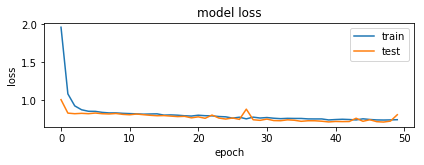

F1_score =  0.669251260459678
confusion matrix
 [[541   0  90]
 [ 39   0  11]
 [207   0 243]]
Test Score =  0.7181869905992064
Test accuracy =  0.6931918658164621
---------------
BKJ.csv
(489, 5, 6, 1) (489, 3)
(211, 5, 6, 1) (211, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               8320      
_______________________________________

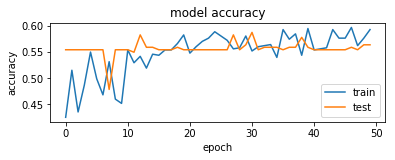

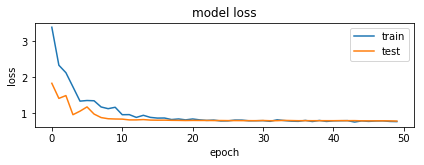

F1_score =  0.46562638120700883
confusion matrix
 [[117   0   0]
 [  7   0   0]
 [ 80   0   7]]
Test Score =  0.7882390833013996
Test accuracy =  0.5876777256834563
---------------
BCV.csv
(4168, 5, 6, 1) (4168, 3)
(1787, 5, 6, 1) (1787, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               8320      
_________________________________

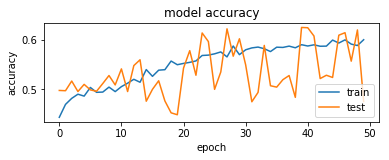

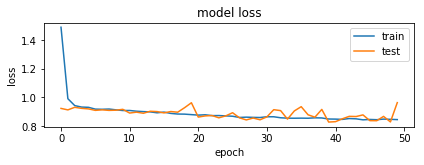

F1_score =  0.5901310443059331
confusion matrix
 [[727   0 159]
 [125   0  33]
 [352   0 391]]
Test Score =  0.8263959898986026
Test accuracy =  0.6256295465595841
---------------
BHB.csv
(1847, 5, 6, 1) (1847, 3)
(793, 5, 6, 1) (793, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               8320      
____________________________________

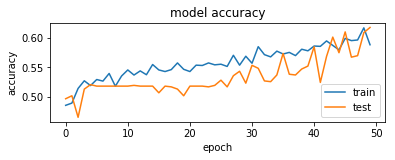

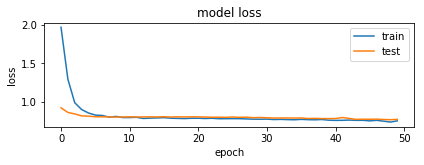

F1_score =  0.5952811770800966
confusion matrix
 [[334   0  77]
 [ 18   0   4]
 [204   0 156]]
Test Score =  0.7681260323915325
Test accuracy =  0.6179066842320888
---------------
BRN.csv
(198, 5, 6, 1) (198, 3)
(86, 5, 6, 1) (86, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               8320      
________________________________________

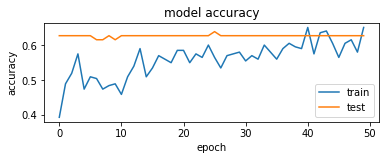

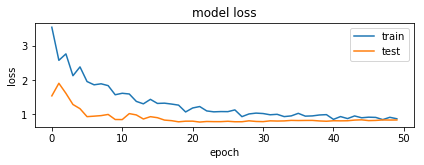

F1_score =  0.5102646564918607
confusion matrix
 [[54  0  0]
 [ 6  0  0]
 [25  0  1]]
Test Score =  0.7914636758870857
Test accuracy =  0.6395348851070848
---------------
BTX.csv
(3700, 5, 6, 1) (3700, 3)
(1587, 5, 6, 1) (1587, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 128)               8320      
___________________________________________

Epoch 25/50
3700/3700 [==============================] - 0s 133us/step - loss: 0.8146 - acc: 0.6241 - val_loss: 0.7967 - val_acc: 0.6396
Epoch 26/50
3700/3700 [==============================] - 0s 134us/step - loss: 0.8019 - acc: 0.6392 - val_loss: 0.7881 - val_acc: 0.6509
Epoch 27/50
3700/3700 [==============================] - 0s 119us/step - loss: 0.8057 - acc: 0.6335 - val_loss: 0.8112 - val_acc: 0.6377
Epoch 28/50
3700/3700 [==============================] - 0s 126us/step - loss: 0.8023 - acc: 0.6422 - val_loss: 0.7873 - val_acc: 0.6503
Epoch 29/50
3700/3700 [==============================] - 0s 116us/step - loss: 0.7904 - acc: 0.6400 - val_loss: 0.7858 - val_acc: 0.6339
Epoch 30/50
3700/3700 [==============================] - 0s 122us/step - loss: 0.7817 - acc: 0.6470 - val_loss: 0.7804 - val_acc: 0.6490
Epoch 31/50
3700/3700 [==============================] - 0s 119us/step - loss: 0.7883 - acc: 0.6432 - val_loss: 0.7800 - val_acc: 0.6522
Epoch 32/50
3700/3700 [==================

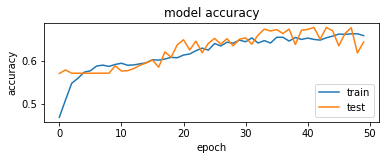

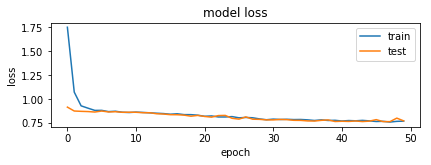

F1_score =  0.6372841213121659
confusion matrix
 [[809   0  97]
 [102   0   6]
 [309   0 264]]
Test Score =  0.7626795372500237
Test accuracy =  0.6761184626581087
---------------
BGI.csv
(451, 5, 6, 1) (451, 3)
(194, 5, 6, 1) (194, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               8320      
______________________________________

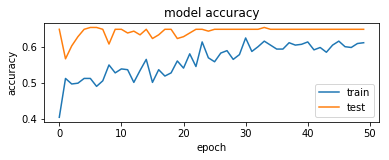

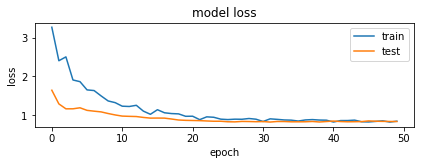

F1_score =  0.5231976075826057
confusion matrix
 [[126   0   0]
 [ 13   0   0]
 [ 54   0   1]]
Test Score =  1.1210827971856618
Test accuracy =  0.654639175257732
---------------
BKTI.csv
(0, 5, 6, 1) (0, 3)
(0, 5, 6, 1) (0, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               8320      
______________________________________________

/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:403: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


AttributeError: 'ProgbarLogger' object has no attribute 'log_values'

In [6]:
path = []
F1_score = []
conf_matrix = []
test_score = []
test_accuracy = []

for item in stock_csv:
    print(item[0])
    filepath, f1_value, conf, ts, ta = model(item[0])
    path.append(filepath)
    F1_score.append(f1_value)
    conf_matrix.append(conf)
    test_score.append(ts)
    test_accuracy.append(ta)
    print("---------------")

In [41]:
print(conf_matrix)

[array([[170,   0,  29],
       [ 11,   0,   2],
       [ 78,   0,  61]]), array([[959,  22, 157],
       [222, 113,  97],
       [268,  18, 508]]), array([[772,  77, 260],
       [113, 107,  82],
       [215,  57, 623]]), array([[782,   2, 225],
       [208,   5,  71],
       [220,   1, 453]]), array([[267,   0,   2],
       [ 69,   0,   0],
       [129,   0,  11]]), array([[192,   0,   8],
       [  5,   0,   0],
       [113,   0,  19]]), array([[48,  0,  0],
       [14,  1,  0],
       [ 9,  0,  0]]), array([[506,   1,  53],
       [ 33,   2,   3],
       [174,   2, 164]]), array([[412,   0,  29],
       [ 63,   0,   0],
       [181,   0,  41]]), array([[582,   0,  55],
       [ 32,   0,   4],
       [166,   0, 170]]), array([[685,   0, 143],
       [ 82,   0,  35],
       [207,   0, 304]]), array([[150,   0,  32],
       [  1,   0,   0],
       [ 83,   0,  93]]), array([[91,  0, 10],
       [ 4,  0,  0],
       [58,  0, 14]]), array([[342,   4,  51],
       [154,  14,  36],
       

RCG.csv


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(2082, 5, 6, 1) (2082, 3)
(893, 5, 6, 1) (893, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_161 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_321 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_161 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_321 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_322 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_322 (Dense)         

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, activation="softmax", kernel_initializer="normal")`


Train on 2082 samples, validate on 893 samples
Epoch 1/50
2082/2082 [==============================] - 13s 6ms/step - loss: 1.8579 - acc: 0.5240 - val_loss: 0.9373 - val_acc: 0.5901
Epoch 2/50
2082/2082 [==============================] - 0s 177us/step - loss: 1.1950 - acc: 0.5120 - val_loss: 0.8770 - val_acc: 0.6058
Epoch 3/50
2082/2082 [==============================] - 0s 160us/step - loss: 1.0028 - acc: 0.5245 - val_loss: 0.8694 - val_acc: 0.5901
Epoch 4/50
2082/2082 [==============================] - 0s 162us/step - loss: 0.9309 - acc: 0.5572 - val_loss: 0.8857 - val_acc: 0.5879
Epoch 5/50
2082/2082 [==============================] - 0s 170us/step - loss: 0.9101 - acc: 0.5634 - val_loss: 0.8935 - val_acc: 0.5913
Epoch 6/50
2082/2082 [==============================] - 0s 169us/step - loss: 0.8993 - acc: 0.5720 - val_loss: 0.8786 - val_acc: 0.5901
Epoch 7/50
2082/2082 [==============================] - 0s 167us/step - loss: 0.8886 - acc: 0.5879 - val_loss: 0.8731 - val_acc: 0.5901
Ep

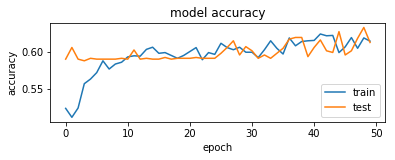

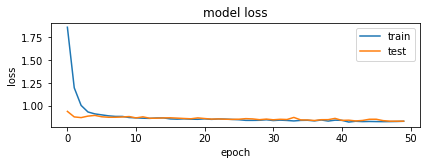

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1_score =  0.555234322561754
confusion matrix
 [[501   0  26]
 [ 60   0   5]
 [237   0  64]]
Test Score =  0.8303013981923811
Test accuracy =  0.6326987687310607
---------------
RVP.csv
(2396, 5, 6, 1) (2396, 3)
(1027, 5, 6, 1) (1027, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_162 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_162 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_323 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_162 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_323 (Dense)            (None, 128)               8320      
___________________________________

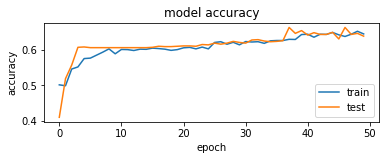

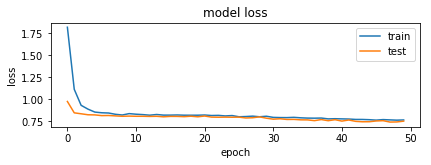

F1_score =  0.616625842562136
confusion matrix
 [[563   0  59]
 [ 36   0   6]
 [246   0 117]]
Test Score =  0.7657842367974553
Test accuracy =  0.6621226874971807
---------------
REI.csv
(18, 5, 6, 1) (18, 3)
(8, 5, 6, 1) (8, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_163 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_163 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_325 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_163 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_325 (Dense)            (None, 128)               8320      
_____________________________________________

Epoch 40/50
Epoch 00040: val_acc did not improve
18/18 [==============================] - 0s 379us/step - loss: 1.4250 - acc: 0.3333 - val_loss: 1.0053 - val_acc: 0.5000
Epoch 41/50
Epoch 00041: val_acc did not improve
18/18 [==============================] - 0s 380us/step - loss: 1.4210 - acc: 0.4444 - val_loss: 1.4549 - val_acc: 0.3750
Epoch 42/50
Epoch 00042: val_acc did not improve
18/18 [==============================] - 0s 414us/step - loss: 1.7476 - acc: 0.3333 - val_loss: 1.3976 - val_acc: 0.3750
Epoch 43/50
Epoch 00043: val_acc did not improve
18/18 [==============================] - 0s 439us/step - loss: 1.1420 - acc: 0.5000 - val_loss: 1.2610 - val_acc: 0.3750
Epoch 44/50
Epoch 00044: val_acc did not improve
18/18 [==============================] - 0s 452us/step - loss: 1.3699 - acc: 0.3889 - val_loss: 1.0625 - val_acc: 0.5000
Epoch 45/50
Epoch 00045: val_acc did not improve
18/18 [==============================] - 0s 432us/step - loss: 0.8175 - acc: 0.7222 - val_loss: 0.998

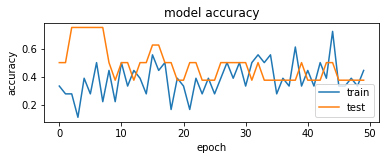

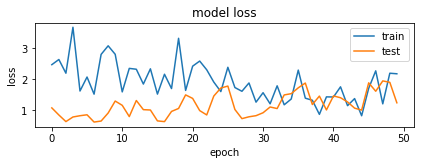

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1_score =  0.7500000000000001
confusion matrix
 [[4 1]
 [1 2]]
Test Score =  0.6298576593399048
Test accuracy =  0.75
---------------
RIF.csv
(2229, 5, 6, 1) (2229, 3)
(956, 5, 6, 1) (956, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_164 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_327 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_164 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_327 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_328 (Dr

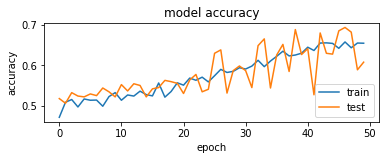

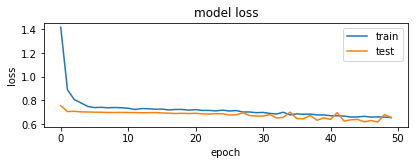

F1_score =  0.6923734292643249
confusion matrix
 [[349   0 112]
 [  1   0   0]
 [180   0 314]]
Test Score =  0.6292963274852003
Test accuracy =  0.6935146446008562
---------------
SNMP.csv
(2183, 5, 6, 1) (2183, 3)
(936, 5, 6, 1) (936, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_165 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_329 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_165 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_329 (Dense)            (None, 128)               8320      
___________________________________

Epoch 26/50
2183/2183 [==============================] - 0s 167us/step - loss: 0.7524 - acc: 0.5969 - val_loss: 0.7184 - val_acc: 0.6090
Epoch 27/50
2183/2183 [==============================] - 0s 167us/step - loss: 0.7439 - acc: 0.6148 - val_loss: 0.7168 - val_acc: 0.6026
Epoch 28/50
2183/2183 [==============================] - 0s 164us/step - loss: 0.7380 - acc: 0.6221 - val_loss: 0.7162 - val_acc: 0.5962
Epoch 29/50
2183/2183 [==============================] - 0s 167us/step - loss: 0.7443 - acc: 0.6148 - val_loss: 0.7135 - val_acc: 0.5983
Epoch 30/50
2183/2183 [==============================] - 0s 186us/step - loss: 0.7324 - acc: 0.6230 - val_loss: 0.7017 - val_acc: 0.6143
Epoch 31/50
2183/2183 [==============================] - 0s 173us/step - loss: 0.7345 - acc: 0.6102 - val_loss: 0.7094 - val_acc: 0.6026
Epoch 32/50
2183/2183 [==============================] - 0s 199us/step - loss: 0.7308 - acc: 0.6193 - val_loss: 0.6941 - val_acc: 0.6303
Epoch 33/50
2183/2183 [==================

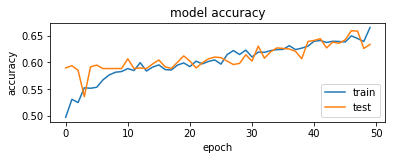

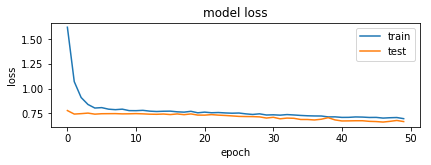

F1_score =  0.607131080534686
confusion matrix
 [[517   0  34]
 [ 10   0   2]
 [273   0 100]]
Test Score =  0.6611258143033737
Test accuracy =  0.6591880341880342
---------------
SAND.csv
(1544, 5, 6, 1) (1544, 3)
(662, 5, 6, 1) (662, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_166 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_166 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_331 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_166 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_331 (Dense)            (None, 128)               8320      
____________________________________

Epoch 26/50
1544/1544 [==============================] - 0s 176us/step - loss: 0.7360 - acc: 0.6114 - val_loss: 0.7588 - val_acc: 0.5770
Epoch 27/50
1544/1544 [==============================] - 0s 167us/step - loss: 0.7388 - acc: 0.6185 - val_loss: 0.7597 - val_acc: 0.5801
Epoch 28/50
1544/1544 [==============================] - 0s 183us/step - loss: 0.7201 - acc: 0.6185 - val_loss: 0.7445 - val_acc: 0.6254
Epoch 29/50
1544/1544 [==============================] - 0s 187us/step - loss: 0.7186 - acc: 0.6367 - val_loss: 0.7603 - val_acc: 0.6360
Epoch 30/50
1544/1544 [==============================] - 0s 168us/step - loss: 0.7233 - acc: 0.6192 - val_loss: 0.7350 - val_acc: 0.6254
Epoch 31/50
1544/1544 [==============================] - 0s 178us/step - loss: 0.7160 - acc: 0.6198 - val_loss: 0.7348 - val_acc: 0.6511
Epoch 32/50
1544/1544 [==============================] - 0s 185us/step - loss: 0.7091 - acc: 0.6425 - val_loss: 0.7273 - val_acc: 0.6722
Epoch 33/50
1544/1544 [==================

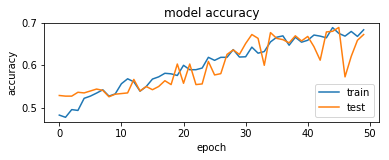

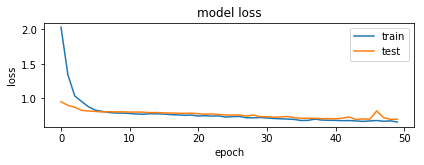

F1_score =  0.6783058914867148
confusion matrix
 [[264   0  89]
 [ 12   0   7]
 [ 98   0 192]]
Test Score =  0.6993416549576014
Test accuracy =  0.6888217531662333
---------------
SEB.csv
(747, 5, 6, 1) (747, 3)
(321, 5, 6, 1) (321, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_167 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_167 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_333 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_167 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_333 (Dense)            (None, 128)               8320      
______________________________________

Epoch 27/50
747/747 [==============================] - 0s 196us/step - loss: 0.7868 - acc: 0.5341 - val_loss: 0.7537 - val_acc: 0.5639
Epoch 28/50
747/747 [==============================] - 0s 185us/step - loss: 0.7852 - acc: 0.5301 - val_loss: 0.7532 - val_acc: 0.5576
Epoch 29/50
747/747 [==============================] - 0s 200us/step - loss: 0.7904 - acc: 0.5355 - val_loss: 0.7537 - val_acc: 0.5639
Epoch 30/50
747/747 [==============================] - 0s 208us/step - loss: 0.7825 - acc: 0.5100 - val_loss: 0.7516 - val_acc: 0.5701
Epoch 31/50
747/747 [==============================] - 0s 176us/step - loss: 0.7884 - acc: 0.5181 - val_loss: 0.7526 - val_acc: 0.5607
Epoch 32/50
747/747 [==============================] - 0s 181us/step - loss: 0.7938 - acc: 0.5448 - val_loss: 0.7517 - val_acc: 0.5639
Epoch 33/50
747/747 [==============================] - 0s 208us/step - loss: 0.7821 - acc: 0.5408 - val_loss: 0.7513 - val_acc: 0.5607
Epoch 34/50
747/747 [==============================] - 

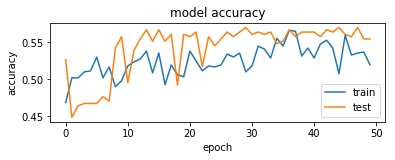

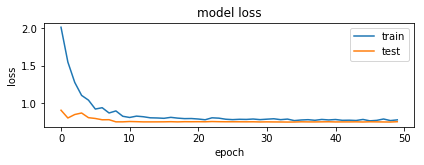

F1_score =  0.47912610753732254
confusion matrix
 [[162   0   7]
 [  5   0   0]
 [126   0  21]]
Test Score =  0.7516192017685959
Test accuracy =  0.5700934579439252
---------------
SVT.csv
(143, 5, 6, 1) (143, 3)
(62, 5, 6, 1) (62, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_335 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_168 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_335 (Dense)            (None, 128)               8320      
_______________________________________

Epoch 26/50
143/143 [==============================] - 0s 386us/step - loss: 1.1944 - acc: 0.4615 - val_loss: 0.9646 - val_acc: 0.6129
Epoch 27/50
143/143 [==============================] - 0s 191us/step - loss: 1.1946 - acc: 0.5035 - val_loss: 0.9785 - val_acc: 0.5645
Epoch 28/50
143/143 [==============================] - 0s 203us/step - loss: 1.2046 - acc: 0.4615 - val_loss: 0.9745 - val_acc: 0.6129
Epoch 29/50
143/143 [==============================] - 0s 197us/step - loss: 1.1375 - acc: 0.4825 - val_loss: 0.9651 - val_acc: 0.5645
Epoch 30/50
143/143 [==============================] - 0s 198us/step - loss: 1.2479 - acc: 0.4965 - val_loss: 0.9779 - val_acc: 0.5323
Epoch 31/50
143/143 [==============================] - 0s 214us/step - loss: 1.0871 - acc: 0.4825 - val_loss: 0.9658 - val_acc: 0.4839
Epoch 32/50
143/143 [==============================] - 0s 228us/step - loss: 1.1455 - acc: 0.4895 - val_loss: 0.9818 - val_acc: 0.4677
Epoch 33/50
143/143 [==============================] - 

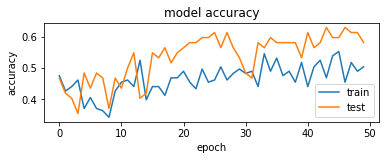

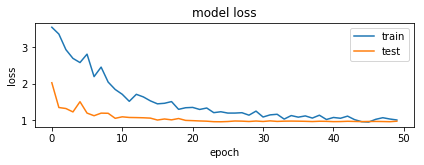

F1_score =  0.5788797945755096
confusion matrix
 [[23  0  5]
 [ 7  0  2]
 [ 9  0 16]]
Test Score =  0.9661927780797405
Test accuracy =  0.6290322561417857
---------------
SIF.csv
(1779, 5, 6, 1) (1779, 3)
(763, 5, 6, 1) (763, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_169 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_337 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_169 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_337 (Dense)            (None, 128)               8320      
_____________________________________________

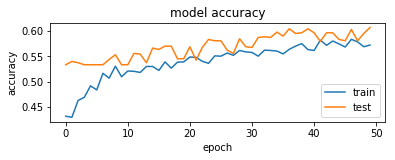

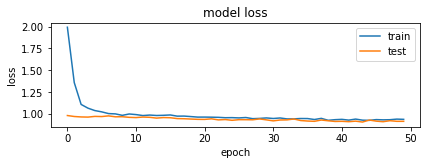

F1_score =  0.5554586178580992
confusion matrix
 [[338   0  69]
 [ 68   0  34]
 [129   0 125]]
Test Score =  0.9123891124094142
Test accuracy =  0.6068152022861716
---------------
XPL.csv
(2066, 5, 6, 1) (2066, 3)
(886, 5, 6, 1) (886, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_170 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_339 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_170 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_339 (Dense)            (None, 128)               8320      
____________________________________

Epoch 26/50
2066/2066 [==============================] - 0s 173us/step - loss: 0.8837 - acc: 0.5736 - val_loss: 0.8517 - val_acc: 0.5666
Epoch 27/50
2066/2066 [==============================] - 0s 188us/step - loss: 0.8658 - acc: 0.5779 - val_loss: 0.8454 - val_acc: 0.5824
Epoch 28/50
2066/2066 [==============================] - 0s 169us/step - loss: 0.8740 - acc: 0.5750 - val_loss: 0.8629 - val_acc: 0.5666
Epoch 29/50
2066/2066 [==============================] - 0s 172us/step - loss: 0.8716 - acc: 0.5842 - val_loss: 0.8496 - val_acc: 0.5666
Epoch 30/50
2066/2066 [==============================] - 0s 174us/step - loss: 0.8703 - acc: 0.5862 - val_loss: 0.8456 - val_acc: 0.5666
Epoch 31/50
2066/2066 [==============================] - 0s 164us/step - loss: 0.8695 - acc: 0.5857 - val_loss: 0.8396 - val_acc: 0.5666
Epoch 32/50
2066/2066 [==============================] - 0s 165us/step - loss: 0.8658 - acc: 0.5799 - val_loss: 0.8407 - val_acc: 0.5824
Epoch 33/50
2066/2066 [==================

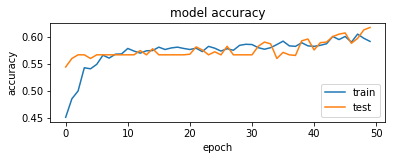

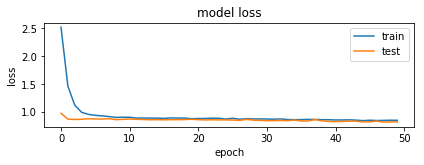

F1_score =  0.5370235451149892
confusion matrix
 [[478   0  24]
 [ 84   0   2]
 [229   0  69]]
Test Score =  0.8163063275894785
Test accuracy =  0.6173814903801774
---------------
SGB.csv
(253, 5, 6, 1) (253, 3)
(109, 5, 6, 1) (109, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_171 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_171 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_341 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_171 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_341 (Dense)            (None, 128)               8320      
______________________________________

Epoch 26/50
253/253 [==============================] - 0s 320us/step - loss: 0.9791 - acc: 0.4941 - val_loss: 0.9693 - val_acc: 0.4679
Epoch 27/50
253/253 [==============================] - 0s 307us/step - loss: 1.0412 - acc: 0.4427 - val_loss: 0.9559 - val_acc: 0.4862
Epoch 28/50
253/253 [==============================] - 0s 211us/step - loss: 1.0461 - acc: 0.3992 - val_loss: 0.9600 - val_acc: 0.4679
Epoch 29/50
253/253 [==============================] - 0s 200us/step - loss: 1.0246 - acc: 0.4783 - val_loss: 0.9546 - val_acc: 0.4495
Epoch 30/50
253/253 [==============================] - 0s 189us/step - loss: 1.0016 - acc: 0.4783 - val_loss: 0.9501 - val_acc: 0.4771
Epoch 31/50
253/253 [==============================] - 0s 185us/step - loss: 0.9759 - acc: 0.5099 - val_loss: 0.9544 - val_acc: 0.4771
Epoch 32/50
253/253 [==============================] - 0s 183us/step - loss: 0.9565 - acc: 0.5336 - val_loss: 0.9495 - val_acc: 0.4862
Epoch 33/50
253/253 [==============================] - 

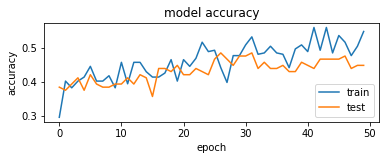

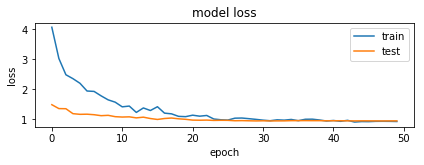

F1_score =  0.45118633343878517
confusion matrix
 [[32  0 14]
 [ 8  0  4]
 [30  0 21]]
Test Score =  0.955916293170474
Test accuracy =  0.48623853539108136
---------------
SRCI.csv
(760, 5, 6, 1) (760, 3)
(326, 5, 6, 1) (326, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_172 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_172 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_343 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_172 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_343 (Dense)            (None, 128)               8320      
_____________________________________________

Epoch 27/50
760/760 [==============================] - 0s 192us/step - loss: 0.7151 - acc: 0.5224 - val_loss: 0.7195 - val_acc: 0.5061
Epoch 28/50
760/760 [==============================] - 0s 178us/step - loss: 0.6973 - acc: 0.5645 - val_loss: 0.7128 - val_acc: 0.5982
Epoch 29/50
760/760 [==============================] - 0s 171us/step - loss: 0.6987 - acc: 0.5697 - val_loss: 0.7119 - val_acc: 0.5890
Epoch 30/50
760/760 [==============================] - 0s 185us/step - loss: 0.7021 - acc: 0.5763 - val_loss: 0.7175 - val_acc: 0.5460
Epoch 31/50
760/760 [==============================] - 0s 178us/step - loss: 0.6941 - acc: 0.5711 - val_loss: 0.7099 - val_acc: 0.5521
Epoch 32/50
760/760 [==============================] - 0s 178us/step - loss: 0.7102 - acc: 0.5368 - val_loss: 0.7522 - val_acc: 0.4785
Epoch 33/50
760/760 [==============================] - 0s 176us/step - loss: 0.7037 - acc: 0.5382 - val_loss: 0.7135 - val_acc: 0.5184
Epoch 34/50
760/760 [==============================] - 

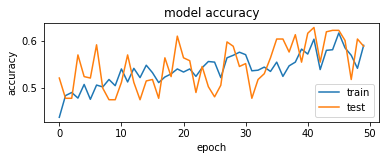

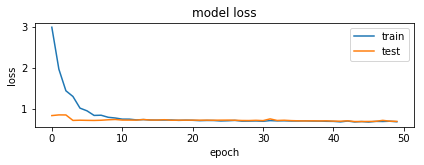

F1_score =  0.6256851865468113
confusion matrix
 [[104   0  52]
 [  0   0   3]
 [ 66   0 101]]
Test Score =  0.6958984176805414
Test accuracy =  0.6288343554625482
---------------
SSY.csv
(1229, 5, 6, 1) (1229, 3)
(528, 5, 6, 1) (528, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_173 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_345 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_173 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_345 (Dense)            (None, 128)               8320      
____________________________________

Epoch 27/50
1229/1229 [==============================] - 0s 182us/step - loss: 0.9358 - acc: 0.5631 - val_loss: 0.9481 - val_acc: 0.5436
Epoch 28/50
1229/1229 [==============================] - 0s 175us/step - loss: 0.9505 - acc: 0.5614 - val_loss: 0.9561 - val_acc: 0.5587
Epoch 29/50
1229/1229 [==============================] - 0s 177us/step - loss: 0.9365 - acc: 0.5533 - val_loss: 0.9482 - val_acc: 0.5436
Epoch 30/50
1229/1229 [==============================] - 0s 178us/step - loss: 0.9355 - acc: 0.5582 - val_loss: 0.9498 - val_acc: 0.5379
Epoch 31/50
1229/1229 [==============================] - 0s 204us/step - loss: 0.9430 - acc: 0.5460 - val_loss: 0.9534 - val_acc: 0.5720
Epoch 32/50
1229/1229 [==============================] - 0s 184us/step - loss: 0.9446 - acc: 0.5484 - val_loss: 0.9456 - val_acc: 0.5511
Epoch 33/50
1229/1229 [==============================] - 0s 198us/step - loss: 0.9406 - acc: 0.5622 - val_loss: 0.9506 - val_acc: 0.5739
Epoch 34/50
1229/1229 [==================

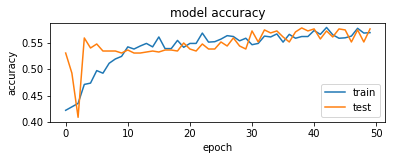

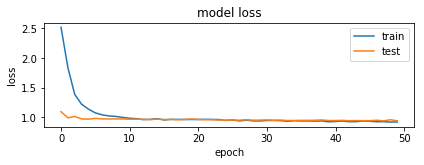

F1_score =  0.4997249994768123
confusion matrix
 [[256   0  24]
 [ 65   0  11]
 [123   0  49]]
Test Score =  0.9526910005193768
Test accuracy =  0.5776515151515151
---------------
SDPI.csv
(832, 5, 6, 1) (832, 3)
(357, 5, 6, 1) (357, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_174 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_347 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_174 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_347 (Dense)            (None, 128)               8320      
_____________________________________

Epoch 26/50
832/832 [==============================] - 0s 190us/step - loss: 0.8249 - acc: 0.5469 - val_loss: 0.7456 - val_acc: 0.6387
Epoch 27/50
832/832 [==============================] - 0s 192us/step - loss: 0.8068 - acc: 0.5817 - val_loss: 0.7455 - val_acc: 0.6415
Epoch 28/50
832/832 [==============================] - 0s 237us/step - loss: 0.8180 - acc: 0.5673 - val_loss: 0.7423 - val_acc: 0.6779
Epoch 29/50
832/832 [==============================] - 0s 187us/step - loss: 0.8148 - acc: 0.5637 - val_loss: 0.7428 - val_acc: 0.6667
Epoch 30/50
832/832 [==============================] - 0s 182us/step - loss: 0.8047 - acc: 0.5877 - val_loss: 0.7481 - val_acc: 0.5938
Epoch 31/50
832/832 [==============================] - 0s 178us/step - loss: 0.8024 - acc: 0.5950 - val_loss: 0.7366 - val_acc: 0.6190
Epoch 32/50
832/832 [==============================] - 0s 178us/step - loss: 0.7999 - acc: 0.5817 - val_loss: 0.7509 - val_acc: 0.5518
Epoch 33/50
832/832 [==============================] - 

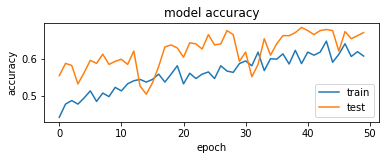

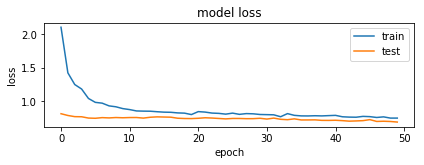

F1_score =  0.6702444286155879
confusion matrix
 [[169   0  38]
 [  9   0   1]
 [ 64   0  76]]
Test Score =  0.7166978948924387
Test accuracy =  0.6862745101378411
---------------
SYN.csv
(2135, 5, 6, 1) (2135, 3)
(916, 5, 6, 1) (916, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_175 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_175 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_349 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_175 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_349 (Dense)            (None, 128)               8320      
____________________________________

Epoch 26/50
2135/2135 [==============================] - 0s 195us/step - loss: 0.7628 - acc: 0.6717 - val_loss: 0.7692 - val_acc: 0.6430
Epoch 27/50
2135/2135 [==============================] - 0s 194us/step - loss: 0.7573 - acc: 0.6731 - val_loss: 0.7793 - val_acc: 0.6528
Epoch 28/50
2135/2135 [==============================] - 0s 190us/step - loss: 0.7465 - acc: 0.6759 - val_loss: 0.7655 - val_acc: 0.6594
Epoch 29/50
2135/2135 [==============================] - 0s 171us/step - loss: 0.7445 - acc: 0.6768 - val_loss: 0.7593 - val_acc: 0.6561
Epoch 30/50
2135/2135 [==============================] - 0s 168us/step - loss: 0.7396 - acc: 0.6806 - val_loss: 0.7557 - val_acc: 0.6561
Epoch 31/50
2135/2135 [==============================] - 0s 184us/step - loss: 0.7403 - acc: 0.6843 - val_loss: 0.7528 - val_acc: 0.6627
Epoch 32/50
2135/2135 [==============================] - 0s 173us/step - loss: 0.7415 - acc: 0.6843 - val_loss: 0.7517 - val_acc: 0.6561
Epoch 33/50
2135/2135 [==================

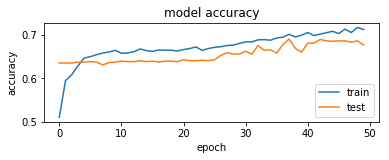

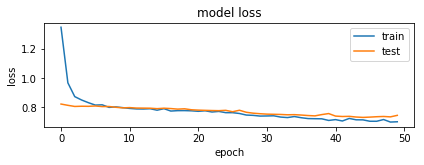

F1_score =  0.6266367302404576
confusion matrix
 [[560   0  22]
 [ 49   0   2]
 [210   0  73]]
Test Score =  0.7409739660904398
Test accuracy =  0.6910480351947801
---------------
TRX.csv
(2442, 5, 6, 1) (2442, 3)
(1047, 5, 6, 1) (1047, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_176 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_176 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_351 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_176 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_351 (Dense)            (None, 128)               8320      
__________________________________

Epoch 26/50
2442/2442 [==============================] - 0s 179us/step - loss: 0.7517 - acc: 0.6368 - val_loss: 0.7436 - val_acc: 0.6189
Epoch 27/50
2442/2442 [==============================] - 0s 175us/step - loss: 0.7439 - acc: 0.6437 - val_loss: 0.7910 - val_acc: 0.5903
Epoch 28/50
2442/2442 [==============================] - 0s 182us/step - loss: 0.7517 - acc: 0.6298 - val_loss: 0.7204 - val_acc: 0.6743
Epoch 29/50
2442/2442 [==============================] - 0s 181us/step - loss: 0.7342 - acc: 0.6429 - val_loss: 0.7169 - val_acc: 0.6762
Epoch 30/50
2442/2442 [==============================] - 0s 197us/step - loss: 0.7389 - acc: 0.6351 - val_loss: 0.7137 - val_acc: 0.6877
Epoch 31/50
2442/2442 [==============================] - 0s 174us/step - loss: 0.7324 - acc: 0.6417 - val_loss: 0.7141 - val_acc: 0.6724
Epoch 32/50
2442/2442 [==============================] - 0s 181us/step - loss: 0.7279 - acc: 0.6556 - val_loss: 0.7093 - val_acc: 0.6791
Epoch 33/50
2442/2442 [==================

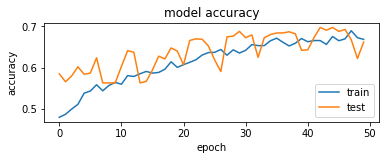

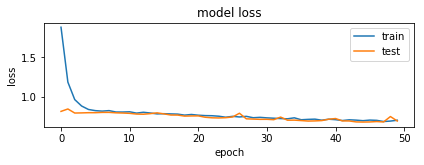

F1_score =  0.6701776269729526
confusion matrix
 [[509   1  79]
 [ 54   1   8]
 [174   1 220]]
Test Score =  0.6791640553683925
Test accuracy =  0.6972301815277981
---------------
TGB.csv
(4105, 5, 6, 1) (4105, 3)
(1760, 5, 6, 1) (1760, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_177 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_177 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_353 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_177 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_353 (Dense)            (None, 128)               8320      
__________________________________

Epoch 25/50
4105/4105 [==============================] - 1s 185us/step - loss: 0.7933 - acc: 0.6475 - val_loss: 0.7636 - val_acc: 0.6699
Epoch 26/50
4105/4105 [==============================] - 1s 175us/step - loss: 0.7845 - acc: 0.6543 - val_loss: 0.7663 - val_acc: 0.6528
Epoch 27/50
4105/4105 [==============================] - 1s 169us/step - loss: 0.7925 - acc: 0.6499 - val_loss: 0.7915 - val_acc: 0.6352
Epoch 28/50
4105/4105 [==============================] - 1s 184us/step - loss: 0.7759 - acc: 0.6575 - val_loss: 0.7535 - val_acc: 0.6784
Epoch 29/50
4105/4105 [==============================] - 1s 175us/step - loss: 0.7915 - acc: 0.6560 - val_loss: 0.7917 - val_acc: 0.6358
Epoch 30/50
4105/4105 [==============================] - 1s 169us/step - loss: 0.7746 - acc: 0.6665 - val_loss: 0.7699 - val_acc: 0.6625
Epoch 31/50
4105/4105 [==============================] - 1s 177us/step - loss: 0.7717 - acc: 0.6660 - val_loss: 0.7590 - val_acc: 0.6670
Epoch 32/50
4105/4105 [==================

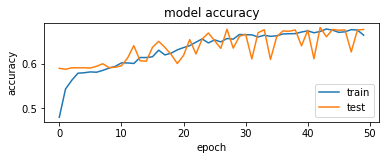

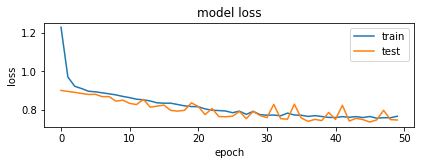

F1_score =  0.6384435416212307
confusion matrix
 [[939   0 102]
 [129   0  12]
 [316   0 262]]
Test Score =  0.7412224888801575
Test accuracy =  0.6823863636363636
---------------
TLGT.csv
(4744, 5, 6, 1) (4744, 3)
(2034, 5, 6, 1) (2034, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_178 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_178 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_355 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_178 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_355 (Dense)            (None, 128)               8320      
_________________________________

Epoch 25/50
4744/4744 [==============================] - 1s 176us/step - loss: 0.9062 - acc: 0.5925 - val_loss: 0.8810 - val_acc: 0.6111
Epoch 26/50
4744/4744 [==============================] - 1s 175us/step - loss: 0.9126 - acc: 0.5906 - val_loss: 0.8993 - val_acc: 0.6023
Epoch 27/50
4744/4744 [==============================] - 1s 183us/step - loss: 0.9038 - acc: 0.5989 - val_loss: 0.9478 - val_acc: 0.5580
Epoch 28/50
4744/4744 [==============================] - 1s 188us/step - loss: 0.9021 - acc: 0.5968 - val_loss: 0.8826 - val_acc: 0.6205
Epoch 29/50
4744/4744 [==============================] - 1s 179us/step - loss: 0.8998 - acc: 0.5999 - val_loss: 0.8739 - val_acc: 0.6273
Epoch 30/50
4744/4744 [==============================] - 1s 171us/step - loss: 0.8974 - acc: 0.5955 - val_loss: 0.8859 - val_acc: 0.6057
Epoch 31/50
4744/4744 [==============================] - 1s 175us/step - loss: 0.8947 - acc: 0.5978 - val_loss: 0.8802 - val_acc: 0.6239
Epoch 32/50
4744/4744 [==================

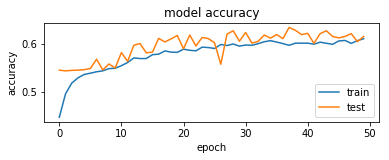

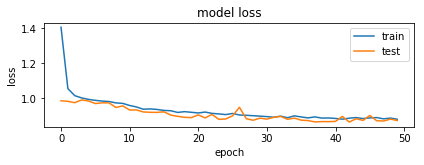

F1_score =  0.5685369016238683
confusion matrix
 [[987   0 123]
 [283   0  52]
 [286   0 303]]
Test Score =  0.8641517192799316
Test accuracy =  0.6342182893199789
---------------
TGC.csv
(3376, 5, 6, 1) (3376, 3)
(1447, 5, 6, 1) (1447, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_179 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_179 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_357 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_179 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_357 (Dense)            (None, 128)               8320      
__________________________________

Epoch 26/50
3376/3376 [==============================] - 1s 180us/step - loss: 0.8797 - acc: 0.6247 - val_loss: 0.8889 - val_acc: 0.6199
Epoch 27/50
3376/3376 [==============================] - 1s 174us/step - loss: 0.8808 - acc: 0.6206 - val_loss: 0.8821 - val_acc: 0.6206
Epoch 28/50
3376/3376 [==============================] - 1s 176us/step - loss: 0.8853 - acc: 0.6235 - val_loss: 0.8852 - val_acc: 0.6151
Epoch 29/50
3376/3376 [==============================] - 1s 176us/step - loss: 0.8740 - acc: 0.6268 - val_loss: 0.8857 - val_acc: 0.6095
Epoch 30/50
3376/3376 [==============================] - 1s 181us/step - loss: 0.8735 - acc: 0.6268 - val_loss: 0.8795 - val_acc: 0.6247
Epoch 31/50
3376/3376 [==============================] - 1s 184us/step - loss: 0.8675 - acc: 0.6289 - val_loss: 0.8774 - val_acc: 0.6261
Epoch 32/50
3376/3376 [==============================] - 1s 187us/step - loss: 0.8692 - acc: 0.6324 - val_loss: 0.8770 - val_acc: 0.6330
Epoch 33/50
3376/3376 [==================

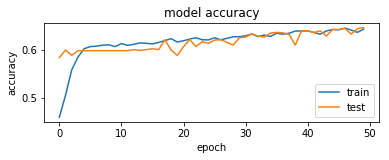

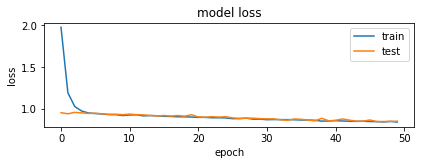

F1_score =  0.5675963667161428
confusion matrix
 [[822   0  43]
 [196   1   8]
 [262   3 112]]
Test Score =  0.8491723592230264
Test accuracy =  0.646164478354398
---------------
TMP.csv
(1630, 5, 6, 1) (1630, 3)
(699, 5, 6, 1) (699, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_180 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_359 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_180 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_359 (Dense)            (None, 128)               8320      
_____________________________________

Epoch 26/50
1630/1630 [==============================] - 0s 187us/step - loss: 0.7295 - acc: 0.5515 - val_loss: 0.7331 - val_acc: 0.5165
Epoch 27/50
1630/1630 [==============================] - 0s 177us/step - loss: 0.7345 - acc: 0.5687 - val_loss: 0.7261 - val_acc: 0.5451
Epoch 28/50
1630/1630 [==============================] - 0s 176us/step - loss: 0.7328 - acc: 0.5571 - val_loss: 0.7267 - val_acc: 0.6023
Epoch 29/50
1630/1630 [==============================] - 0s 185us/step - loss: 0.7268 - acc: 0.5687 - val_loss: 0.7241 - val_acc: 0.5322
Epoch 30/50
1630/1630 [==============================] - 0s 177us/step - loss: 0.7324 - acc: 0.5515 - val_loss: 0.7299 - val_acc: 0.5379
Epoch 31/50
1630/1630 [==============================] - 0s 197us/step - loss: 0.7343 - acc: 0.5472 - val_loss: 0.7194 - val_acc: 0.6166
Epoch 32/50
1630/1630 [==============================] - 0s 183us/step - loss: 0.7320 - acc: 0.5914 - val_loss: 0.7303 - val_acc: 0.5236
Epoch 33/50
1630/1630 [==================

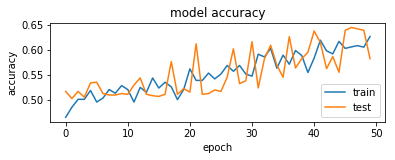

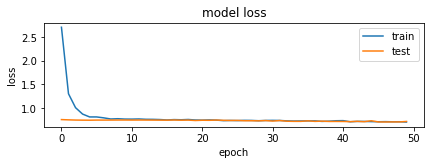

F1_score =  0.6380184436403363
confusion matrix
 [[268   0  89]
 [  6   1   4]
 [149   0 182]]
Test Score =  0.7000329483391048
Test accuracy =  0.645207438516685
---------------
TAT.csv
(1811, 5, 6, 1) (1811, 3)
(777, 5, 6, 1) (777, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_181 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_361 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_181 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_361 (Dense)            (None, 128)               8320      
_____________________________________

Epoch 26/50
1811/1811 [==============================] - 0s 185us/step - loss: 0.7934 - acc: 0.6449 - val_loss: 0.8102 - val_acc: 0.6525
Epoch 27/50
1811/1811 [==============================] - 0s 187us/step - loss: 0.7869 - acc: 0.6494 - val_loss: 0.8045 - val_acc: 0.6306
Epoch 28/50
1811/1811 [==============================] - 0s 187us/step - loss: 0.7908 - acc: 0.6527 - val_loss: 0.8022 - val_acc: 0.6332
Epoch 29/50
1811/1811 [==============================] - 0s 184us/step - loss: 0.7861 - acc: 0.6538 - val_loss: 0.7923 - val_acc: 0.6409
Epoch 30/50
1811/1811 [==============================] - 0s 182us/step - loss: 0.7871 - acc: 0.6565 - val_loss: 0.7946 - val_acc: 0.6538
Epoch 31/50
1811/1811 [==============================] - 0s 187us/step - loss: 0.7773 - acc: 0.6582 - val_loss: 0.8005 - val_acc: 0.6281
Epoch 32/50
1811/1811 [==============================] - 0s 185us/step - loss: 0.7838 - acc: 0.6538 - val_loss: 0.7918 - val_acc: 0.6486
Epoch 33/50
1811/1811 [==================

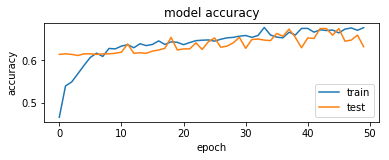

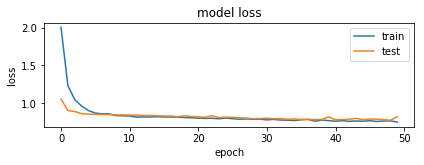

F1_score =  0.6298087384458806
confusion matrix
 [[428   0  49]
 [ 43   0  11]
 [150   0  96]]
Test Score =  0.7973872476869875
Test accuracy =  0.6743886745037413
---------------
TRXC.csv
(1820, 5, 6, 1) (1820, 3)
(781, 5, 6, 1) (781, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_182 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_182 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_363 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_182 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_363 (Dense)            (None, 128)               8320      
___________________________________

Epoch 27/50
1820/1820 [==============================] - 0s 180us/step - loss: 0.9027 - acc: 0.5742 - val_loss: 0.8790 - val_acc: 0.6018
Epoch 28/50
1820/1820 [==============================] - 0s 182us/step - loss: 0.9052 - acc: 0.5775 - val_loss: 0.8842 - val_acc: 0.6018
Epoch 29/50
1820/1820 [==============================] - 0s 188us/step - loss: 0.9083 - acc: 0.5775 - val_loss: 0.8837 - val_acc: 0.6018
Epoch 30/50
1820/1820 [==============================] - 0s 183us/step - loss: 0.9071 - acc: 0.5797 - val_loss: 0.8753 - val_acc: 0.6018
Epoch 31/50
1820/1820 [==============================] - 0s 190us/step - loss: 0.8978 - acc: 0.5802 - val_loss: 0.8742 - val_acc: 0.6018
Epoch 32/50
1820/1820 [==============================] - 0s 184us/step - loss: 0.8984 - acc: 0.5813 - val_loss: 0.8780 - val_acc: 0.6018
Epoch 33/50
1820/1820 [==============================] - 0s 193us/step - loss: 0.8941 - acc: 0.5824 - val_loss: 0.8738 - val_acc: 0.6018
Epoch 34/50
1820/1820 [==================

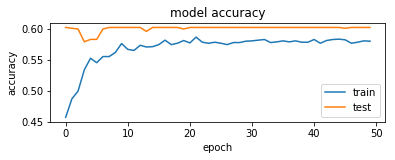

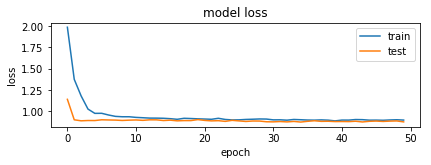

F1_score =  0.45218626635183534
confusion matrix
 [[470   0   0]
 [ 67   0   0]
 [244   0   0]]
Test Score =  1.138918906946341
Test accuracy =  0.6017925737761963
---------------
TMQ.csv
(1231, 5, 6, 1) (1231, 3)
(528, 5, 6, 1) (528, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_183 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_183 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_365 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_183 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_365 (Dense)            (None, 128)               8320      
____________________________________

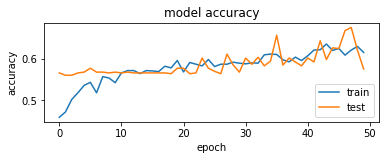

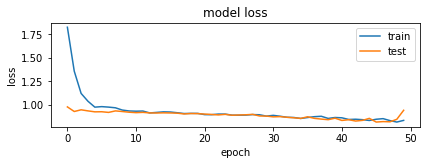

F1_score =  0.6287241541353384
confusion matrix
 [[270   0  29]
 [ 41   0  11]
 [ 90   0  87]]
Test Score =  0.818099988229347
Test accuracy =  0.6761363636363636
---------------
TRT.csv
(765, 5, 6, 1) (765, 3)
(329, 5, 6, 1) (329, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_184 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_184 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_367 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_184 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_367 (Dense)            (None, 128)               8320      
_______________________________________

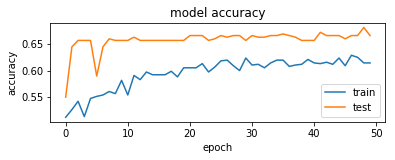

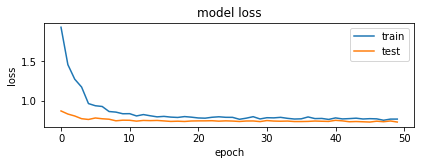

F1_score =  0.5817004247296108
confusion matrix
 [[214   0   2]
 [  9   0   0]
 [ 94   0  10]]
Test Score =  0.7414679797224724
Test accuracy =  0.6808510645544638
---------------
UAMY.csv
(459, 5, 6, 1) (459, 3)
(197, 5, 6, 1) (197, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_185 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_369 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_185 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_369 (Dense)            (None, 128)               8320      
_____________________________________

459/459 [==============================] - 0s 208us/step - loss: 0.9519 - acc: 0.5011 - val_loss: 0.9746 - val_acc: 0.4315
Epoch 28/50
459/459 [==============================] - 0s 277us/step - loss: 0.9671 - acc: 0.4837 - val_loss: 0.9762 - val_acc: 0.4569
Epoch 29/50
459/459 [==============================] - 0s 204us/step - loss: 0.9413 - acc: 0.5098 - val_loss: 0.9757 - val_acc: 0.4061
Epoch 30/50
459/459 [==============================] - 0s 198us/step - loss: 0.9382 - acc: 0.5033 - val_loss: 0.9749 - val_acc: 0.4213
Epoch 31/50
459/459 [==============================] - 0s 205us/step - loss: 0.9390 - acc: 0.5011 - val_loss: 0.9742 - val_acc: 0.4162
Epoch 32/50
459/459 [==============================] - 0s 201us/step - loss: 0.9624 - acc: 0.4967 - val_loss: 0.9758 - val_acc: 0.4112
Epoch 33/50
459/459 [==============================] - 0s 209us/step - loss: 0.9563 - acc: 0.5011 - val_loss: 0.9777 - val_acc: 0.4010
Epoch 34/50
459/459 [==============================] - 0s 208us/ste

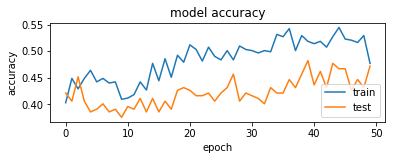

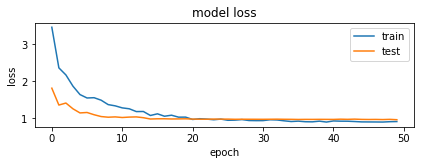

F1_score =  0.3556810657892097
confusion matrix
 [[89  0  4]
 [26  0  4]
 [68  0  6]]
Test Score =  0.9722005982084323
Test accuracy =  0.48223350253807107
---------------
UUU.csv
(612, 5, 6, 1) (612, 3)
(263, 5, 6, 1) (263, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_186 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_186 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_371 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_186 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_371 (Dense)            (None, 128)               8320      
______________________________________________

Epoch 26/50
612/612 [==============================] - 0s 257us/step - loss: 0.8275 - acc: 0.5245 - val_loss: 0.8044 - val_acc: 0.5817
Epoch 27/50
612/612 [==============================] - 0s 199us/step - loss: 0.8119 - acc: 0.5229 - val_loss: 0.8093 - val_acc: 0.5513
Epoch 28/50
612/612 [==============================] - 0s 203us/step - loss: 0.8313 - acc: 0.5229 - val_loss: 0.8127 - val_acc: 0.5171
Epoch 29/50
612/612 [==============================] - 0s 191us/step - loss: 0.8379 - acc: 0.5033 - val_loss: 0.8044 - val_acc: 0.5703
Epoch 30/50
612/612 [==============================] - 0s 197us/step - loss: 0.8269 - acc: 0.4984 - val_loss: 0.8130 - val_acc: 0.5133
Epoch 31/50
612/612 [==============================] - 0s 195us/step - loss: 0.8210 - acc: 0.5294 - val_loss: 0.8030 - val_acc: 0.5513
Epoch 32/50
612/612 [==============================] - 0s 199us/step - loss: 0.8195 - acc: 0.5523 - val_loss: 0.7976 - val_acc: 0.5627
Epoch 33/50
612/612 [==============================] - 

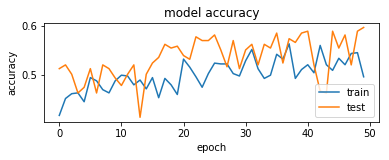

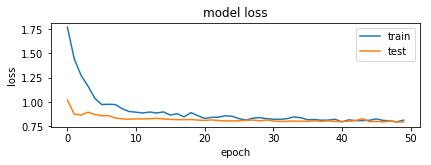

F1_score =  0.524491560537544
confusion matrix
 [[131   0   4]
 [  9   1   2]
 [ 91   0  25]]
Test Score =  0.7916911214930024
Test accuracy =  0.5969581750182598
---------------
UQM.csv
(3275, 5, 6, 1) (3275, 3)
(1404, 5, 6, 1) (1404, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_187 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_187 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_373 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_187 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_373 (Dense)            (None, 128)               8320      
___________________________________

Epoch 25/50
3275/3275 [==============================] - 1s 188us/step - loss: 0.7515 - acc: 0.6595 - val_loss: 0.7508 - val_acc: 0.6944
Epoch 26/50
3275/3275 [==============================] - 1s 191us/step - loss: 0.7525 - acc: 0.6666 - val_loss: 0.7470 - val_acc: 0.7009
Epoch 27/50
3275/3275 [==============================] - 1s 187us/step - loss: 0.7492 - acc: 0.6623 - val_loss: 0.7429 - val_acc: 0.6717
Epoch 28/50
3275/3275 [==============================] - 1s 179us/step - loss: 0.7543 - acc: 0.6544 - val_loss: 0.7698 - val_acc: 0.6873
Epoch 29/50
3275/3275 [==============================] - 1s 189us/step - loss: 0.7457 - acc: 0.6711 - val_loss: 0.7508 - val_acc: 0.7051
Epoch 30/50
3275/3275 [==============================] - 1s 181us/step - loss: 0.7432 - acc: 0.6745 - val_loss: 0.7301 - val_acc: 0.6952
Epoch 31/50
3275/3275 [==============================] - 1s 180us/step - loss: 0.7429 - acc: 0.6605 - val_loss: 0.7256 - val_acc: 0.7009
Epoch 32/50
3275/3275 [==================

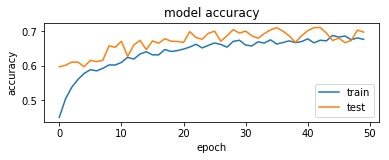

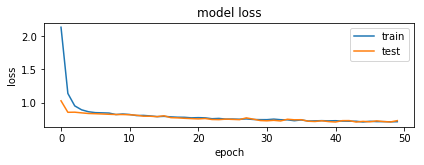

F1_score =  0.6838929944528351
confusion matrix
 [[712   0 124]
 [ 70   0  19]
 [192   0 287]]
Test Score =  0.7287253187252924
Test accuracy =  0.7115384618780891
---------------
URG.csv
(1896, 5, 6, 1) (1896, 3)
(814, 5, 6, 1) (814, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_188 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_375 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_188 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_375 (Dense)            (None, 128)               8320      
____________________________________

Epoch 25/50
1896/1896 [==============================] - 0s 191us/step - loss: 0.8447 - acc: 0.6234 - val_loss: 0.8534 - val_acc: 0.6265
Epoch 26/50
1896/1896 [==============================] - 0s 184us/step - loss: 0.8411 - acc: 0.6282 - val_loss: 0.8219 - val_acc: 0.6425
Epoch 27/50
1896/1896 [==============================] - 0s 201us/step - loss: 0.8481 - acc: 0.6329 - val_loss: 0.8037 - val_acc: 0.6450
Epoch 28/50
1896/1896 [==============================] - 0s 206us/step - loss: 0.8319 - acc: 0.6355 - val_loss: 0.8143 - val_acc: 0.6671
Epoch 29/50
1896/1896 [==============================] - 0s 192us/step - loss: 0.8410 - acc: 0.6303 - val_loss: 0.7953 - val_acc: 0.6560
Epoch 30/50
1896/1896 [==============================] - 0s 190us/step - loss: 0.8422 - acc: 0.6303 - val_loss: 0.7943 - val_acc: 0.6511
Epoch 31/50
1896/1896 [==============================] - 0s 192us/step - loss: 0.8342 - acc: 0.6308 - val_loss: 0.7894 - val_acc: 0.6450
Epoch 32/50
1896/1896 [==================

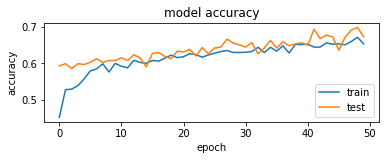

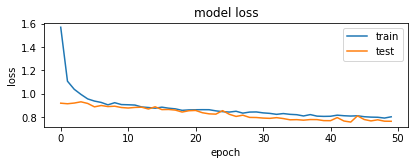

F1_score =  0.6578569206072608
confusion matrix
 [[399   0  76]
 [ 64   0  25]
 [ 80   0 170]]
Test Score =  0.7626640338276762
Test accuracy =  0.6990171993100965
---------------
UEC.csv
(2133, 5, 6, 1) (2133, 3)
(915, 5, 6, 1) (915, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_189 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_189 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_377 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_189 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_377 (Dense)            (None, 128)               8320      
____________________________________

Epoch 25/50
2133/2133 [==============================] - 0s 186us/step - loss: 0.6461 - acc: 0.7117 - val_loss: 0.5980 - val_acc: 0.7508
Epoch 26/50
2133/2133 [==============================] - 0s 184us/step - loss: 0.6580 - acc: 0.7140 - val_loss: 0.5982 - val_acc: 0.7607
Epoch 27/50
2133/2133 [==============================] - 0s 197us/step - loss: 0.6486 - acc: 0.7140 - val_loss: 0.6032 - val_acc: 0.7508
Epoch 28/50
2133/2133 [==============================] - 0s 187us/step - loss: 0.6502 - acc: 0.7201 - val_loss: 0.5937 - val_acc: 0.7443
Epoch 29/50
2133/2133 [==============================] - 0s 205us/step - loss: 0.6464 - acc: 0.7239 - val_loss: 0.5923 - val_acc: 0.7749
Epoch 30/50
2133/2133 [==============================] - 0s 191us/step - loss: 0.6317 - acc: 0.7173 - val_loss: 0.6179 - val_acc: 0.7410
Epoch 31/50
2133/2133 [==============================] - 0s 191us/step - loss: 0.6420 - acc: 0.7103 - val_loss: 0.5845 - val_acc: 0.7628
Epoch 32/50
2133/2133 [==================

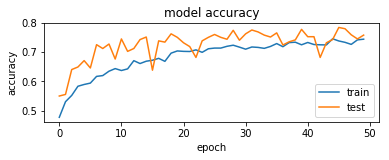

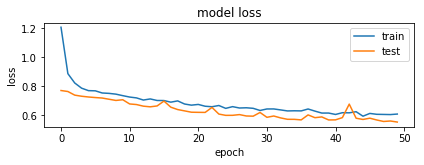

F1_score =  0.7766175322588051
confusion matrix
 [[454   0  94]
 [ 11   0   9]
 [ 83   0 264]]
Test Score =  0.5783890333983416
Test accuracy =  0.7846994533564875
---------------
VHC.csv
(508, 5, 6, 1) (508, 3)
(218, 5, 6, 1) (218, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_190 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_190 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_379 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_190 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_379 (Dense)            (None, 128)               8320      
______________________________________

Epoch 27/50
508/508 [==============================] - 0s 198us/step - loss: 0.8450 - acc: 0.5886 - val_loss: 0.8127 - val_acc: 0.6147
Epoch 28/50
508/508 [==============================] - 0s 253us/step - loss: 0.8208 - acc: 0.5650 - val_loss: 0.8092 - val_acc: 0.6239
Epoch 29/50
508/508 [==============================] - 0s 191us/step - loss: 0.7813 - acc: 0.5984 - val_loss: 0.8214 - val_acc: 0.6193
Epoch 30/50
508/508 [==============================] - 0s 205us/step - loss: 0.7924 - acc: 0.6004 - val_loss: 0.8222 - val_acc: 0.5963
Epoch 31/50
508/508 [==============================] - 0s 198us/step - loss: 0.8094 - acc: 0.6122 - val_loss: 0.8154 - val_acc: 0.6055
Epoch 32/50
508/508 [==============================] - 0s 198us/step - loss: 0.7993 - acc: 0.5965 - val_loss: 0.8280 - val_acc: 0.5963
Epoch 33/50
508/508 [==============================] - 0s 205us/step - loss: 0.8319 - acc: 0.5846 - val_loss: 0.8138 - val_acc: 0.6147
Epoch 34/50
508/508 [==============================] - 

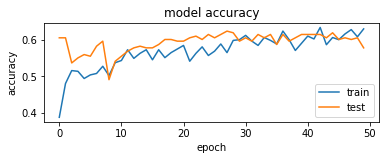

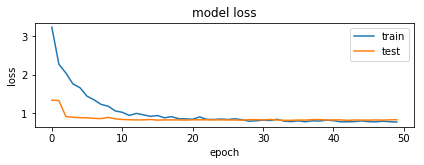

F1_score =  0.5265399737876801
confusion matrix
 [[127   0   5]
 [ 16   0   0]
 [ 61   0   9]]
Test Score =  0.8092165720572165
Test accuracy =  0.6238532112825901
---------------
VGZ.csv
(4312, 5, 6, 1) (4312, 3)
(1849, 5, 6, 1) (1849, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_191 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_191 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_381 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_191 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_381 (Dense)            (None, 128)               8320      
__________________________________

Epoch 24/50
4312/4312 [==============================] - 1s 193us/step - loss: 0.8859 - acc: 0.5346 - val_loss: 0.8587 - val_acc: 0.5608
Epoch 25/50
4312/4312 [==============================] - 1s 182us/step - loss: 0.8791 - acc: 0.5468 - val_loss: 0.8558 - val_acc: 0.5598
Epoch 26/50
4312/4312 [==============================] - 1s 181us/step - loss: 0.8845 - acc: 0.5438 - val_loss: 0.8466 - val_acc: 0.5592
Epoch 27/50
4312/4312 [==============================] - 1s 189us/step - loss: 0.8771 - acc: 0.5508 - val_loss: 0.8408 - val_acc: 0.5625
Epoch 28/50
4312/4312 [==============================] - 1s 181us/step - loss: 0.8729 - acc: 0.5531 - val_loss: 0.8452 - val_acc: 0.5576
Epoch 29/50
4312/4312 [==============================] - 1s 179us/step - loss: 0.8718 - acc: 0.5448 - val_loss: 0.8458 - val_acc: 0.5554
Epoch 30/50
4312/4312 [==============================] - 1s 182us/step - loss: 0.8697 - acc: 0.5443 - val_loss: 0.8396 - val_acc: 0.5560
Epoch 31/50
4312/4312 [==================

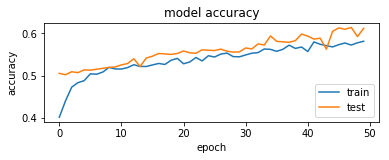

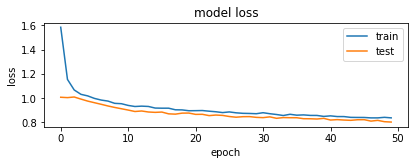

F1_score =  0.6095161609421546
confusion matrix
 [[574 199 160]
 [ 86 335   1]
 [199  69 226]]
Test Score =  0.81476101168044
Test accuracy =  0.6138453218278013
---------------
VNRX.csv
(343, 5, 6, 1) (343, 3)
(147, 5, 6, 1) (147, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_192 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_383 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_192 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_383 (Dense)            (None, 128)               8320      
_______________________________________

343/343 [==============================] - 0s 205us/step - loss: 0.7730 - acc: 0.6122 - val_loss: 0.7319 - val_acc: 0.6939
Epoch 28/50
343/343 [==============================] - 0s 202us/step - loss: 0.8429 - acc: 0.5948 - val_loss: 0.7257 - val_acc: 0.6939
Epoch 29/50
343/343 [==============================] - 0s 206us/step - loss: 0.8380 - acc: 0.6122 - val_loss: 0.7260 - val_acc: 0.7007
Epoch 30/50
343/343 [==============================] - 0s 228us/step - loss: 0.8160 - acc: 0.6064 - val_loss: 0.7283 - val_acc: 0.6939
Epoch 31/50
343/343 [==============================] - 0s 204us/step - loss: 0.8106 - acc: 0.6006 - val_loss: 0.7163 - val_acc: 0.7007
Epoch 32/50
343/343 [==============================] - 0s 203us/step - loss: 0.7735 - acc: 0.6210 - val_loss: 0.7045 - val_acc: 0.7007
Epoch 33/50
343/343 [==============================] - 0s 216us/step - loss: 0.8345 - acc: 0.6064 - val_loss: 0.7195 - val_acc: 0.6939
Epoch 34/50
343/343 [==============================] - 0s 246us/ste

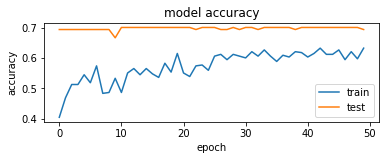

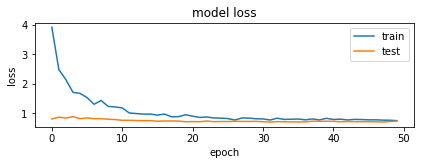

F1_score =  0.5901574229100361
confusion matrix
 [[101   0   0]
 [  4   0   0]
 [ 40   0   2]]
Test Score =  0.7642162867954799
Test accuracy =  0.7006802708924222
---------------
ERC.csv
(2797, 5, 6, 1) (2797, 3)
(1199, 5, 6, 1) (1199, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_193 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_193 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_385 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_193 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_385 (Dense)            (None, 128)               8320      
__________________________________

Epoch 27/50
2797/2797 [==============================] - 1s 203us/step - loss: 0.7846 - acc: 0.5406 - val_loss: 0.7592 - val_acc: 0.6489
Epoch 28/50
2797/2797 [==============================] - 1s 199us/step - loss: 0.7754 - acc: 0.5495 - val_loss: 0.7545 - val_acc: 0.6647
Epoch 29/50
2797/2797 [==============================] - 1s 189us/step - loss: 0.7788 - acc: 0.5445 - val_loss: 0.7574 - val_acc: 0.6055
Epoch 30/50
2797/2797 [==============================] - 1s 193us/step - loss: 0.7730 - acc: 0.5513 - val_loss: 0.7545 - val_acc: 0.5496
Epoch 31/50
2797/2797 [==============================] - 1s 183us/step - loss: 0.7715 - acc: 0.5585 - val_loss: 0.7541 - val_acc: 0.6022
Epoch 32/50
2797/2797 [==============================] - 1s 183us/step - loss: 0.7639 - acc: 0.5681 - val_loss: 0.7388 - val_acc: 0.6606
Epoch 33/50
2797/2797 [==============================] - 1s 190us/step - loss: 0.7653 - acc: 0.5720 - val_loss: 0.7444 - val_acc: 0.6230
Epoch 34/50
2797/2797 [==================

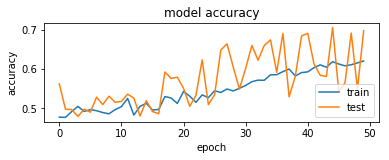

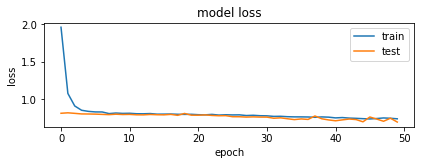

F1_score =  0.6968247081669602
confusion matrix
 [[465   0 131]
 [ 18   0  11]
 [192   0 382]]
Test Score =  0.6911286282181441
Test accuracy =  0.7064220186966076
---------------
EAD.csv
(2857, 5, 6, 1) (2857, 3)
(1225, 5, 6, 1) (1225, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_194 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_194 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_387 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_194 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_387 (Dense)            (None, 128)               8320      
__________________________________

Epoch 26/50
2857/2857 [==============================] - 1s 219us/step - loss: 0.7755 - acc: 0.5565 - val_loss: 0.7671 - val_acc: 0.5371
Epoch 27/50
2857/2857 [==============================] - 1s 212us/step - loss: 0.7703 - acc: 0.5492 - val_loss: 0.7606 - val_acc: 0.5886
Epoch 28/50
2857/2857 [==============================] - 1s 197us/step - loss: 0.7632 - acc: 0.5723 - val_loss: 0.7536 - val_acc: 0.6016
Epoch 29/50
2857/2857 [==============================] - 1s 190us/step - loss: 0.7597 - acc: 0.5590 - val_loss: 0.8315 - val_acc: 0.5037
Epoch 30/50
2857/2857 [==============================] - 1s 187us/step - loss: 0.7615 - acc: 0.5744 - val_loss: 0.7732 - val_acc: 0.5233
Epoch 31/50
2857/2857 [==============================] - 1s 191us/step - loss: 0.7597 - acc: 0.5740 - val_loss: 0.7680 - val_acc: 0.5257
Epoch 32/50
2857/2857 [==============================] - 1s 187us/step - loss: 0.7524 - acc: 0.5775 - val_loss: 0.7590 - val_acc: 0.5249
Epoch 33/50
2857/2857 [==================

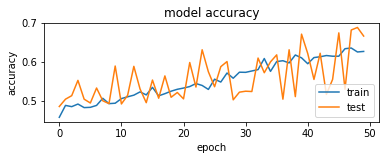

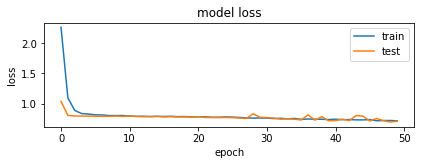

F1_score =  0.6771405702518765
confusion matrix
 [[484   0 100]
 [ 20   0   9]
 [252   0 360]]
Test Score =  0.6943191009151692
Test accuracy =  0.6889795919827052
---------------
WRN.csv
(191, 5, 6, 1) (191, 3)
(83, 5, 6, 1) (83, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_195 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_195 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_389 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_195 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_389 (Dense)            (None, 128)               8320      
________________________________________

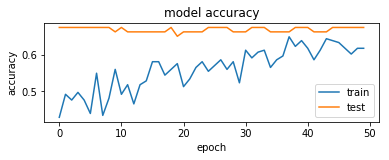

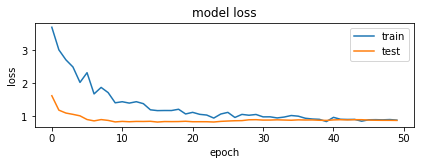

F1_score =  0.562118208939069
confusion matrix
 [[55  1  0]
 [10  1  0]
 [16  0  0]]
Test Score =  0.9070081875984928
Test accuracy =  0.6746987980532358
---------------
ERH.csv
(2640, 5, 6, 1) (2640, 3)
(1132, 5, 6, 1) (1132, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_196 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_196 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_391 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_196 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_391 (Dense)            (None, 128)               8320      
____________________________________________

Epoch 26/50
2640/2640 [==============================] - 1s 199us/step - loss: 0.6976 - acc: 0.6201 - val_loss: 0.7317 - val_acc: 0.5733
Epoch 27/50
2640/2640 [==============================] - 1s 193us/step - loss: 0.7023 - acc: 0.6117 - val_loss: 0.7114 - val_acc: 0.6502
Epoch 28/50
2640/2640 [==============================] - 1s 196us/step - loss: 0.6963 - acc: 0.6295 - val_loss: 0.8021 - val_acc: 0.4903
Epoch 29/50
2640/2640 [==============================] - 1s 197us/step - loss: 0.6988 - acc: 0.6261 - val_loss: 0.8001 - val_acc: 0.4956
Epoch 30/50
2640/2640 [==============================] - 1s 208us/step - loss: 0.6886 - acc: 0.6284 - val_loss: 0.7004 - val_acc: 0.7067
Epoch 31/50
2640/2640 [==============================] - 1s 200us/step - loss: 0.6869 - acc: 0.6420 - val_loss: 0.7487 - val_acc: 0.5742
Epoch 32/50
2640/2640 [==============================] - 1s 203us/step - loss: 0.6849 - acc: 0.6360 - val_loss: 0.6960 - val_acc: 0.6829
Epoch 33/50
2640/2640 [==================

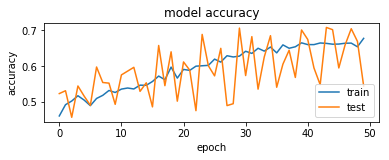

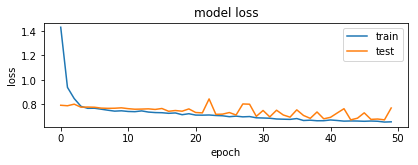

F1_score =  0.6984083483072356
confusion matrix
 [[316   0 201]
 [  3   0  18]
 [108   0 486]]
Test Score =  0.6717359792217349
Test accuracy =  0.7084805651604076
---------------
WTT.csv
(4407, 5, 6, 1) (4407, 3)
(1890, 5, 6, 1) (1890, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_197 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_197 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_393 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_197 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_393 (Dense)            (None, 128)               8320      
__________________________________

Epoch 25/50
4407/4407 [==============================] - 1s 206us/step - loss: 0.8311 - acc: 0.6338 - val_loss: 0.8382 - val_acc: 0.6132
Epoch 26/50
4407/4407 [==============================] - 1s 192us/step - loss: 0.8263 - acc: 0.6319 - val_loss: 0.8333 - val_acc: 0.6185
Epoch 27/50
4407/4407 [==============================] - 1s 186us/step - loss: 0.8182 - acc: 0.6281 - val_loss: 0.8355 - val_acc: 0.6212
Epoch 28/50
4407/4407 [==============================] - 1s 196us/step - loss: 0.8213 - acc: 0.6299 - val_loss: 0.8523 - val_acc: 0.6302
Epoch 29/50
4407/4407 [==============================] - 1s 192us/step - loss: 0.8219 - acc: 0.6340 - val_loss: 0.8200 - val_acc: 0.6397
Epoch 30/50
4407/4407 [==============================] - 1s 187us/step - loss: 0.8226 - acc: 0.6340 - val_loss: 0.8316 - val_acc: 0.6545
Epoch 31/50
4407/4407 [==============================] - 1s 184us/step - loss: 0.8154 - acc: 0.6392 - val_loss: 0.8250 - val_acc: 0.6286
Epoch 32/50
4407/4407 [==================

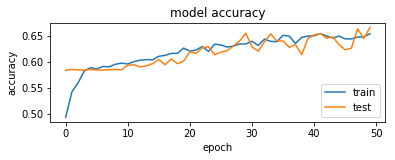

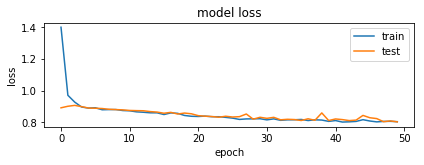

F1_score =  0.6172430602599966
confusion matrix
 [[999   0 104]
 [129   0  28]
 [371   0 259]]
Test Score =  0.8028568932619045
Test accuracy =  0.6656084656084656
---------------
YUMA.csv
(1043, 5, 6, 1) (1043, 3)
(447, 5, 6, 1) (447, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_198 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_198 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_395 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_198 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_395 (Dense)            (None, 128)               8320      
___________________________________

Epoch 26/50
1043/1043 [==============================] - 0s 198us/step - loss: 0.6159 - acc: 0.7795 - val_loss: 0.5626 - val_acc: 0.7830
Epoch 27/50
1043/1043 [==============================] - 0s 198us/step - loss: 0.6042 - acc: 0.7795 - val_loss: 0.5781 - val_acc: 0.7897
Epoch 28/50
1043/1043 [==============================] - 0s 232us/step - loss: 0.6140 - acc: 0.7766 - val_loss: 0.5748 - val_acc: 0.7919
Epoch 29/50
1043/1043 [==============================] - 0s 234us/step - loss: 0.5902 - acc: 0.7728 - val_loss: 0.5541 - val_acc: 0.7964
Epoch 30/50
1043/1043 [==============================] - 0s 216us/step - loss: 0.5937 - acc: 0.7766 - val_loss: 0.5615 - val_acc: 0.7852
Epoch 31/50
1043/1043 [==============================] - 0s 193us/step - loss: 0.5904 - acc: 0.7756 - val_loss: 0.5677 - val_acc: 0.7875
Epoch 32/50
1043/1043 [==============================] - 0s 209us/step - loss: 0.5745 - acc: 0.7766 - val_loss: 0.5405 - val_acc: 0.7875
Epoch 33/50
1043/1043 [==================

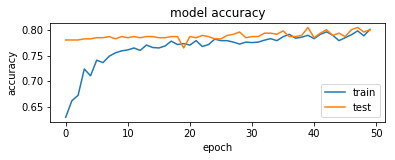

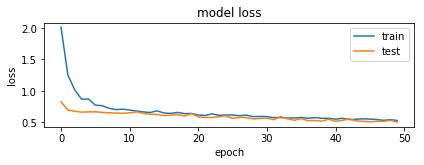

F1_score =  0.7606079820666426
confusion matrix
 [[ 25  36   0]
 [ 14 335   0]
 [  5  32   0]]
Test Score =  0.5492653067346654
Test accuracy =  0.8053691257833101
---------------
CPHI.csv
(788, 5, 6, 1) (788, 3)
(339, 5, 6, 1) (339, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_199 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_199 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_397 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_199 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_397 (Dense)            (None, 128)               8320      
_____________________________________

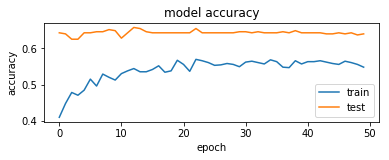

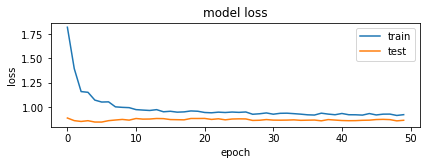

F1_score =  0.5472334577545984
confusion matrix
 [[215   0   3]
 [ 51   0   0]
 [ 62   0   8]]
Test Score =  0.8777535992034416
Test accuracy =  0.6578171077379434
---------------
AE.csv
(2114, 5, 6, 1) (2114, 3)
(906, 5, 6, 1) (906, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_200 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_200 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_399 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_200 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_399 (Dense)            (None, 128)               8320      
_____________________________________

Epoch 26/50
2114/2114 [==============================] - 0s 197us/step - loss: 0.8300 - acc: 0.5530 - val_loss: 0.8289 - val_acc: 0.5055
Epoch 27/50
2114/2114 [==============================] - 0s 191us/step - loss: 0.8358 - acc: 0.5563 - val_loss: 0.8045 - val_acc: 0.5773
Epoch 28/50
2114/2114 [==============================] - 0s 194us/step - loss: 0.8222 - acc: 0.5629 - val_loss: 0.7935 - val_acc: 0.5949
Epoch 29/50
2114/2114 [==============================] - 0s 198us/step - loss: 0.8305 - acc: 0.5662 - val_loss: 0.8238 - val_acc: 0.5121
Epoch 30/50
2114/2114 [==============================] - 0s 199us/step - loss: 0.8173 - acc: 0.5795 - val_loss: 0.7982 - val_acc: 0.5971
Epoch 31/50
2114/2114 [==============================] - 0s 209us/step - loss: 0.8197 - acc: 0.5833 - val_loss: 0.7887 - val_acc: 0.6225
Epoch 32/50
2114/2114 [==============================] - 0s 191us/step - loss: 0.8193 - acc: 0.5728 - val_loss: 0.7927 - val_acc: 0.5773
Epoch 33/50
2114/2114 [==================

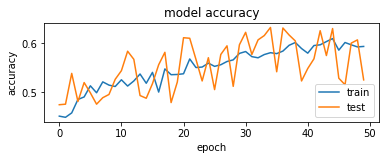

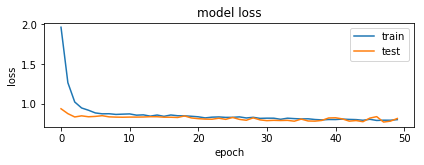

F1_score =  0.6231794721039338
confusion matrix
 [[305  12 111]
 [ 65  28  11]
 [130   4 240]]
Test Score =  0.7817037025297977
Test accuracy =  0.6324503312574054
---------------
HUSA.csv
(1753, 5, 6, 1) (1753, 3)
(752, 5, 6, 1) (752, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_201 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_201 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_401 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_201 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_401 (Dense)            (None, 128)               8320      
___________________________________

Epoch 26/50
1753/1753 [==============================] - 0s 223us/step - loss: 0.8275 - acc: 0.5414 - val_loss: 0.7993 - val_acc: 0.5971
Epoch 27/50
1753/1753 [==============================] - 0s 197us/step - loss: 0.8185 - acc: 0.5482 - val_loss: 0.7946 - val_acc: 0.5944
Epoch 28/50
1753/1753 [==============================] - 0s 196us/step - loss: 0.8238 - acc: 0.5476 - val_loss: 0.7938 - val_acc: 0.5771
Epoch 29/50
1753/1753 [==============================] - 0s 200us/step - loss: 0.8126 - acc: 0.5533 - val_loss: 0.7946 - val_acc: 0.5971
Epoch 30/50
1753/1753 [==============================] - 0s 198us/step - loss: 0.8117 - acc: 0.5625 - val_loss: 0.7896 - val_acc: 0.5878
Epoch 31/50
1753/1753 [==============================] - 0s 215us/step - loss: 0.8117 - acc: 0.5699 - val_loss: 0.7865 - val_acc: 0.6011
Epoch 32/50
1753/1753 [==============================] - 0s 196us/step - loss: 0.8090 - acc: 0.5528 - val_loss: 0.7951 - val_acc: 0.5705
Epoch 33/50
1753/1753 [==================

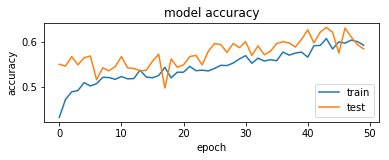

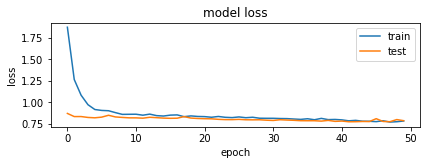

F1_score =  0.6320513597780854
confusion matrix
 [[284  57  70]
 [ 35  69   1]
 [104   9 123]]
Test Score =  0.7747369928562895
Test accuracy =  0.6329787234042553
---------------
GSAT.csv
(890, 5, 6, 1) (890, 3)
(382, 5, 6, 1) (382, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_202 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_202 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_403 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_202 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_403 (Dense)            (None, 128)               8320      
_____________________________________

Epoch 27/50
890/890 [==============================] - 0s 209us/step - loss: 0.8205 - acc: 0.5854 - val_loss: 0.8174 - val_acc: 0.5890
Epoch 28/50
890/890 [==============================] - 0s 199us/step - loss: 0.8178 - acc: 0.5933 - val_loss: 0.8165 - val_acc: 0.5890
Epoch 29/50
890/890 [==============================] - 0s 207us/step - loss: 0.8047 - acc: 0.5966 - val_loss: 0.8139 - val_acc: 0.5890
Epoch 30/50
890/890 [==============================] - 0s 200us/step - loss: 0.8145 - acc: 0.6011 - val_loss: 0.8138 - val_acc: 0.5890
Epoch 31/50
890/890 [==============================] - 0s 200us/step - loss: 0.8138 - acc: 0.5978 - val_loss: 0.8163 - val_acc: 0.5890
Epoch 32/50
890/890 [==============================] - 0s 201us/step - loss: 0.8028 - acc: 0.6034 - val_loss: 0.8121 - val_acc: 0.5890
Epoch 33/50
890/890 [==============================] - 0s 207us/step - loss: 0.8073 - acc: 0.5955 - val_loss: 0.8154 - val_acc: 0.5890
Epoch 34/50
890/890 [==============================] - 

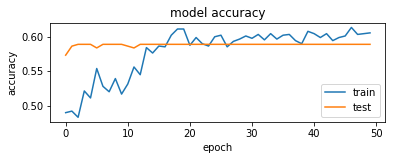

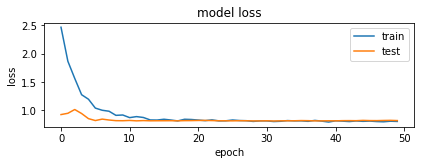

F1_score =  0.43665956510863657
confusion matrix
 [[225   0   0]
 [ 21   0   0]
 [136   0   0]]
Test Score =  1.0151008479882284
Test accuracy =  0.5890052377865577
---------------
EVBN.csv
(513, 5, 6, 1) (513, 3)
(220, 5, 6, 1) (220, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_203 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_203 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_405 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_203 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_405 (Dense)            (None, 128)               8320      
____________________________________

Epoch 27/50
513/513 [==============================] - 0s 219us/step - loss: 0.7981 - acc: 0.5965 - val_loss: 0.7697 - val_acc: 0.5727
Epoch 28/50
513/513 [==============================] - 0s 212us/step - loss: 0.8117 - acc: 0.5965 - val_loss: 0.7677 - val_acc: 0.5818
Epoch 29/50
513/513 [==============================] - 0s 211us/step - loss: 0.7921 - acc: 0.6062 - val_loss: 0.7707 - val_acc: 0.5545
Epoch 30/50
513/513 [==============================] - 0s 206us/step - loss: 0.7802 - acc: 0.5984 - val_loss: 0.7632 - val_acc: 0.5818
Epoch 31/50
513/513 [==============================] - 0s 206us/step - loss: 0.7742 - acc: 0.6257 - val_loss: 0.7611 - val_acc: 0.5818
Epoch 32/50
513/513 [==============================] - 0s 216us/step - loss: 0.7739 - acc: 0.6082 - val_loss: 0.7620 - val_acc: 0.5864
Epoch 33/50
513/513 [==============================] - 0s 211us/step - loss: 0.7683 - acc: 0.6082 - val_loss: 0.7683 - val_acc: 0.5773
Epoch 34/50
513/513 [==============================] - 

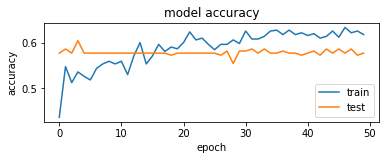

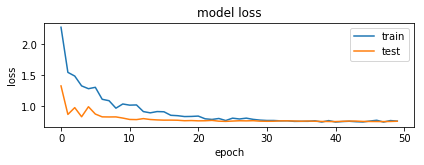

F1_score =  0.4881246430017247
confusion matrix
 [[126   0   1]
 [  4   0   1]
 [ 81   0   7]]
Test Score =  0.8340777440504594
Test accuracy =  0.6045454534617337
---------------
AMPE.csv
(1380, 5, 6, 1) (1380, 3)
(592, 5, 6, 1) (592, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_204 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_204 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_407 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_204 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_407 (Dense)            (None, 128)               8320      
___________________________________

Epoch 26/50
1380/1380 [==============================] - 0s 292us/step - loss: 0.7506 - acc: 0.6087 - val_loss: 0.7184 - val_acc: 0.6622
Epoch 27/50
1380/1380 [==============================] - 0s 210us/step - loss: 0.7408 - acc: 0.6080 - val_loss: 0.7200 - val_acc: 0.6571
Epoch 28/50
1380/1380 [==============================] - 0s 206us/step - loss: 0.7310 - acc: 0.6283 - val_loss: 0.7362 - val_acc: 0.6014
Epoch 29/50
1380/1380 [==============================] - 0s 200us/step - loss: 0.7341 - acc: 0.6058 - val_loss: 0.7285 - val_acc: 0.6182
Epoch 30/50
1380/1380 [==============================] - 0s 204us/step - loss: 0.7315 - acc: 0.6239 - val_loss: 0.7088 - val_acc: 0.6301
Epoch 31/50
1380/1380 [==============================] - 0s 199us/step - loss: 0.7226 - acc: 0.6348 - val_loss: 0.7507 - val_acc: 0.5895
Epoch 32/50
1380/1380 [==============================] - 0s 211us/step - loss: 0.7297 - acc: 0.6152 - val_loss: 0.7108 - val_acc: 0.6588
Epoch 33/50
1380/1380 [==================

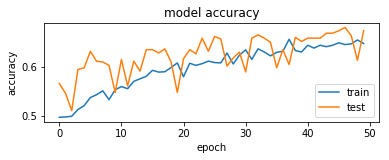

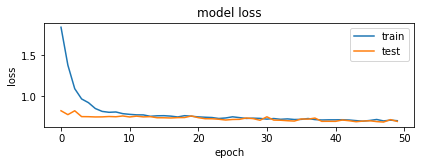

F1_score =  0.6643505075787774
confusion matrix
 [[267   0  61]
 [ 17   0   1]
 [110   0 136]]
Test Score =  0.692560576103829
Test accuracy =  0.6807432432432432
---------------
IMO.csv
(5740, 5, 6, 1) (5740, 3)
(2460, 5, 6, 1) (2460, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_205 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_205 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_409 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_205 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_409 (Dense)            (None, 128)               8320      
___________________________________

Epoch 25/50
5740/5740 [==============================] - 1s 203us/step - loss: 0.7421 - acc: 0.6427 - val_loss: 0.7046 - val_acc: 0.6654
Epoch 26/50
5740/5740 [==============================] - 1s 193us/step - loss: 0.7319 - acc: 0.6314 - val_loss: 0.7023 - val_acc: 0.6817
Epoch 27/50
5740/5740 [==============================] - 1s 197us/step - loss: 0.7339 - acc: 0.6359 - val_loss: 0.7031 - val_acc: 0.6752
Epoch 28/50
5740/5740 [==============================] - 1s 196us/step - loss: 0.7238 - acc: 0.6526 - val_loss: 0.6915 - val_acc: 0.6817
Epoch 29/50
5740/5740 [==============================] - 1s 190us/step - loss: 0.7266 - acc: 0.6510 - val_loss: 0.7722 - val_acc: 0.5699
Epoch 30/50
5740/5740 [==============================] - 1s 200us/step - loss: 0.7289 - acc: 0.6449 - val_loss: 0.6921 - val_acc: 0.6939
Epoch 31/50
5740/5740 [==============================] - 1s 196us/step - loss: 0.7287 - acc: 0.6423 - val_loss: 0.7353 - val_acc: 0.5797
Epoch 32/50
5740/5740 [==================

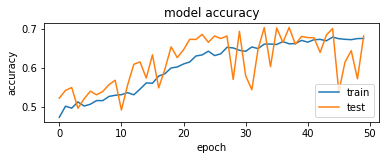

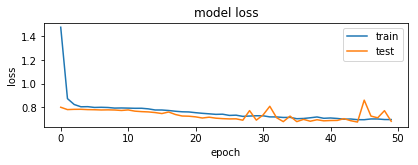

F1_score =  0.6897688724154769
confusion matrix
 [[787   0 393]
 [ 67   0  20]
 [249   0 944]]
Test Score =  0.6829009327462049
Test accuracy =  0.7036585365853658
---------------
NHS.csv
(2783, 5, 6, 1) (2783, 3)
(1193, 5, 6, 1) (1193, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_206 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_206 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_411 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_206 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_411 (Dense)            (None, 128)               8320      
__________________________________

Epoch 25/50
2783/2783 [==============================] - 1s 213us/step - loss: 0.7205 - acc: 0.5950 - val_loss: 0.7181 - val_acc: 0.6672
Epoch 26/50
2783/2783 [==============================] - 1s 202us/step - loss: 0.7152 - acc: 0.6137 - val_loss: 0.7332 - val_acc: 0.5909
Epoch 27/50
2783/2783 [==============================] - 1s 205us/step - loss: 0.7135 - acc: 0.6119 - val_loss: 0.7116 - val_acc: 0.6479
Epoch 28/50
2783/2783 [==============================] - 1s 209us/step - loss: 0.7180 - acc: 0.5943 - val_loss: 0.7172 - val_acc: 0.6940
Epoch 29/50
2783/2783 [==============================] - 1s 204us/step - loss: 0.7113 - acc: 0.6159 - val_loss: 0.7448 - val_acc: 0.5767
Epoch 30/50
2783/2783 [==============================] - 1s 199us/step - loss: 0.7009 - acc: 0.6234 - val_loss: 0.7069 - val_acc: 0.6463
Epoch 31/50
2783/2783 [==============================] - 1s 200us/step - loss: 0.7064 - acc: 0.6274 - val_loss: 0.7074 - val_acc: 0.6940
Epoch 32/50
2783/2783 [==================

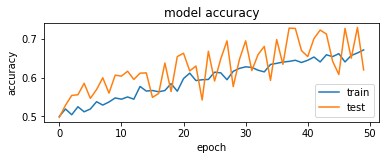

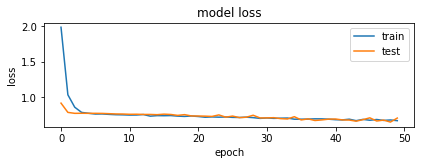

F1_score =  0.7177633192237249
confusion matrix
 [[365   0 210]
 [  7   0  18]
 [ 89   0 504]]
Test Score =  0.6489725312263348
Test accuracy =  0.7284157587416714
---------------
PLAG.csv
(293, 5, 6, 1) (293, 3)
(126, 5, 6, 1) (126, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_207 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_207 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_413 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_207 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_413 (Dense)            (None, 128)               8320      
_____________________________________

Epoch 27/50
293/293 [==============================] - 0s 226us/step - loss: 0.8223 - acc: 0.5904 - val_loss: 0.7347 - val_acc: 0.5000
Epoch 28/50
293/293 [==============================] - 0s 226us/step - loss: 0.8036 - acc: 0.5597 - val_loss: 0.7275 - val_acc: 0.5476
Epoch 29/50
293/293 [==============================] - 0s 218us/step - loss: 0.8419 - acc: 0.5324 - val_loss: 0.7253 - val_acc: 0.5317
Epoch 30/50
293/293 [==============================] - 0s 234us/step - loss: 0.8046 - acc: 0.5358 - val_loss: 0.7300 - val_acc: 0.4921
Epoch 31/50
293/293 [==============================] - 0s 214us/step - loss: 0.8089 - acc: 0.5324 - val_loss: 0.7273 - val_acc: 0.5159
Epoch 32/50
293/293 [==============================] - 0s 213us/step - loss: 0.8069 - acc: 0.5768 - val_loss: 0.7251 - val_acc: 0.5079
Epoch 33/50
293/293 [==============================] - 0s 234us/step - loss: 0.7988 - acc: 0.5904 - val_loss: 0.7211 - val_acc: 0.5714
Epoch 34/50
293/293 [==============================] - 

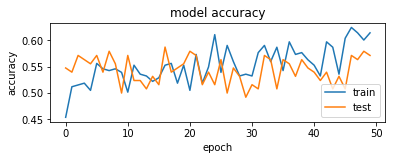

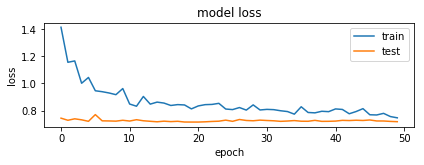

F1_score =  0.4737019101425881
confusion matrix
 [[70  0  2]
 [ 1  0  0]
 [49  0  4]]
Test Score =  0.7191400622564649
Test accuracy =  0.5873015863554818
---------------
NGD.csv
(2368, 5, 6, 1) (2368, 3)
(1016, 5, 6, 1) (1016, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_208 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_208 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_415 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_208 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_415 (Dense)            (None, 128)               8320      
___________________________________________

Epoch 25/50
2368/2368 [==============================] - 0s 209us/step - loss: 0.6390 - acc: 0.6753 - val_loss: 0.6654 - val_acc: 0.6506
Epoch 26/50
2368/2368 [==============================] - 0s 198us/step - loss: 0.6335 - acc: 0.6753 - val_loss: 0.6435 - val_acc: 0.6634
Epoch 27/50
2368/2368 [==============================] - 0s 197us/step - loss: 0.6364 - acc: 0.6824 - val_loss: 0.6375 - val_acc: 0.6762
Epoch 28/50
2368/2368 [==============================] - 0s 198us/step - loss: 0.6260 - acc: 0.6812 - val_loss: 0.6333 - val_acc: 0.6752
Epoch 29/50
2368/2368 [==============================] - 0s 193us/step - loss: 0.6385 - acc: 0.6706 - val_loss: 0.6385 - val_acc: 0.6850
Epoch 30/50
2368/2368 [==============================] - 0s 198us/step - loss: 0.6350 - acc: 0.6782 - val_loss: 0.6352 - val_acc: 0.6752
Epoch 31/50
2368/2368 [==============================] - 0s 196us/step - loss: 0.6196 - acc: 0.6791 - val_loss: 0.6357 - val_acc: 0.6850
Epoch 32/50
2368/2368 [==================

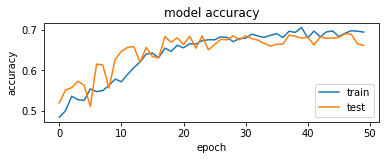

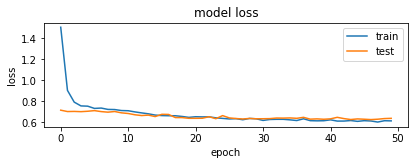

F1_score =  0.6879829845933625
confusion matrix
 [[380   0 158]
 [  6   0   0]
 [151   0 321]]
Test Score =  0.6277335089022719
Test accuracy =  0.6899606299212598
---------------
AUMN.csv
(261, 5, 6, 1) (261, 3)
(113, 5, 6, 1) (113, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_209 (Conv2D)          (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_209 (MaxPoolin (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_417 (Dropout)        (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_209 (Flatten)        (None, 64)                0         
_________________________________________________________________
dense_417 (Dense)            (None, 128)               8320      
_____________________________________

Epoch 27/50
261/261 [==============================] - 0s 245us/step - loss: 1.0447 - acc: 0.5402 - val_loss: 1.0365 - val_acc: 0.4779
Epoch 28/50
261/261 [==============================] - 0s 236us/step - loss: 1.0572 - acc: 0.5326 - val_loss: 1.0332 - val_acc: 0.4779
Epoch 29/50
261/261 [==============================] - 0s 238us/step - loss: 1.0074 - acc: 0.5441 - val_loss: 1.0309 - val_acc: 0.4779
Epoch 30/50
261/261 [==============================] - 0s 240us/step - loss: 1.0641 - acc: 0.5556 - val_loss: 1.0284 - val_acc: 0.4779
Epoch 31/50
261/261 [==============================] - 0s 238us/step - loss: 1.0418 - acc: 0.5402 - val_loss: 1.0298 - val_acc: 0.4779
Epoch 32/50
261/261 [==============================] - 0s 235us/step - loss: 0.9762 - acc: 0.5326 - val_loss: 1.0268 - val_acc: 0.4779
Epoch 33/50
261/261 [==============================] - 0s 231us/step - loss: 1.0129 - acc: 0.5479 - val_loss: 1.0234 - val_acc: 0.4779
Epoch 34/50
261/261 [==============================] - 

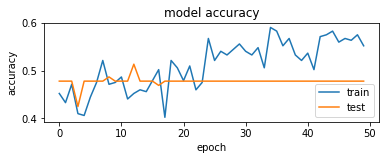

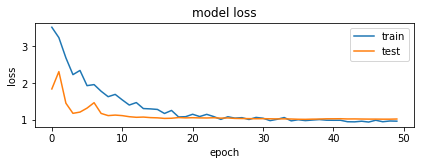

F1_score =  0.41597563806983534
confusion matrix
 [[50  4  0]
 [29  8  0]
 [16  6  0]]
Test Score =  1.0670001918235712
Test accuracy =  0.513274339975509
---------------


In [35]:
for i in range(156, len(stock_csv)):
    print(stock_csv[i][0])
    filepath, f1_value, conf, ts, ta = model(stock_csv[i][0])
    path.append(filepath)
    F1_score.append(f1_value)
    conf_matrix.append(conf)
    test_score.append(ts)
    test_accuracy.append(ta)
    print("---------------")

In [39]:
print("average F1_score = ", np.mean(F1_score))
print("max F1_score = ", max(F1_score))
print("min F1_score = ", min(F1_score))
print("std F1_score = ", np.std(F1_score, ddof=1))

average F1_score =  0.6054836778053556
max F1_score =  0.8755221386800335
min F1_score =  0.297439225867359
std F1_score =  0.09300818913173516


In [40]:
print("average accuracy = ", np.mean(test_accuracy))
print("max accuracy = ", max(test_accuracy))
print("min accuracy = ", min(test_accuracy))
print("std accuracy = ", np.std(test_accuracy, ddof=1))

average accuracy =  0.6562930760345375
max accuracy =  0.9047619104385376
min accuracy =  0.46710526472643804
std accuracy =  0.06410337413796796


In [42]:
# 保存数据F1_score以及test_accuracy
output = open('212NYSE_Composite_result.xls','w',encoding='gbk')
output.write('F1_score\Accuracy\n')
for i in range(0, len(stock_csv)):
    output.write(str(F1_score[i]))    #write函数不能写int类型的参数，所以使用str()转化
    output.write('\t')   #相当于Tab一下，换一个单元格
    output.write(str(test_accuracy[i]))
    output.write('\n')       #写完一行立马换行
output.close()